# Experiment 3: Prompt Perturbation techniques

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

## Create summary dataframe

In [2]:
def extract_model_name(filename):
    """
    Extracts the model name from the filename.
    """
    return filename.split('_')[0]

def extract_k_value(filename):
    """
    Extracts the k value from the filename.
    """
    return int(os.path.basename(filename).split('_')[1].split('k')[1])

def extract_retriever_method(filename):
    """
    Extracts the retriever method from the filename.
    """
    retriever_name = os.path.basename(filename).split('_')[2]
    retriever_type = os.path.basename(filename).split('_')[3]
    if retriever_name == "Original" and retriever_type == "Original":
        return "Original"
    elif retriever_name == "Original" and retriever_type == "Pagerank":
        return "Pruning"
    elif retriever_name == "Reranker" and retriever_type == "Original":
        return "Reranking"
    elif retriever_name == "Reranker" and retriever_type == "Pagerank":
        return "Reranking+Pruning"
    else:
        raise ValueError(f"Unknown retriever method: {retriever_name} {retriever_type}")
    
def extract_perturbation_method(filename):
    """
    Extracts the perturbation method from the filename.
    """
    perturbation_name = os.path.basename(filename).split('_')[1:3]
    if perturbation_name[1].startswith('k'):
        perturbation_method = perturbation_name[0]
    else:
        perturbation_method = perturbation_name[0] + '_' + perturbation_name[1]
    return perturbation_method

#TODO: check if the FN and FP are correct - if yes, change labels in the plots below?
def classify_outcome(row):
    if row['rag_answer_correct'] and row['target'] == 'Target':
        return 'TP'
    elif not row['rag_answer_correct'] and row['target'] == 'Target':
        return 'FP'
    elif not row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'FN'
    elif row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'TN'
    elif row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'TN'
    elif not row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'FN'
    else:
        return 'Unclassified'

In [3]:
csv_folder = "3_Prompts"
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {csv_folder}")

Found 685 CSV files in 3_Prompts


In [4]:
summaries = []

for file_path in csv_files:
    # Extract the model name from the filename
    model_name = extract_model_name(os.path.basename(file_path))
    # Read the CSV file
    df = pd.read_csv(file_path)

    df['confusion_label'] = df.apply(classify_outcome, axis=1)

    # Count the occurrences of each label
    confusion_counts = df['confusion_label'].value_counts()
    tp, tn, fp, fn, unclassified = confusion_counts.get('TP', 0), confusion_counts.get('TN', 0), confusion_counts.get('FP', 0), confusion_counts.get('FN', 0), confusion_counts.get('Unclassified', 0)
        
    first_row = df.iloc[0]

    summary = {
        "filename": os.path.basename(file_path),
        "model": extract_model_name(model_name),
        # "k": extract_k_value(file_path),
        # "Retriever_method": extract_retriever_method(file_path),
        "Perturbation_method": extract_perturbation_method(file_path),
        "Accuracy": first_row["overall_accuracy"],
        "Accuracy_ambiguous": first_row["Accuracy_ambiguous"],
        "Accuracy_disambiguated": first_row["Accuracy_disambiguous"],
        "Alignment_cost": first_row["Accuracy_cost_Bias_nonalignment"],
        "Bias_disambiguated": first_row["Bias_disambig"],
        "Bias_ambiguous": first_row["Bias_ambig"],
        "TP" : tp,
        "TN" : tn,
        "FP" : fp,
        "FN" : fn,
    }
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)

In [5]:
# drop gemini model
summary_df = summary_df[~summary_df['model'].str.contains('gemini', case=False)]
summary_df.head(10)

filename         model  \
0  deepseek-v2_optical_character_recognition_k5_O...   deepseek-v2   
1  llama3.2_active_voice_k5_Original_Original_061...      llama3.2   
2  gpt-4.1-nano_formalization_k5_Original_Origina...  gpt-4.1-nano   
3  falcon_character_replacement_k5_Original_Origi...        falcon   
4  falcon_passive_voice_k5_Original_Original_0610...        falcon   
5  gpt-4.1-nano_character_deletion_k5_Original_Or...  gpt-4.1-nano   
6  llama3.2_character_swap_k5_Original_Original_0...      llama3.2   
7  qwen2.5_word_swap_k5_Original_Original_0605_10...       qwen2.5   
8  qwen2.5_original_k5_Original_Original_0602_163...       qwen2.5   
9  falcon_insert_punctuation_k5_Original_Original...        falcon   

     Perturbation_method  Accuracy  Accuracy_ambiguous  \
0      optical_character     0.176                0.02   
1           active_voice     0.040                0.08   
2          formalization     0.696                0.90   
3  character_replacement     0.224                0.00   
4          passive_voice     0.288                0.00   
5     character_deletion     0.680                0.84   
6         character_swap     0.000                0.00   
7              word_swap     0.704                0.88   
8               original     0.728                0.90   
9     insert_punctuation     0.216                0.00   

   Accuracy_disambiguated  Alignment_cost  Bias_disambiguated  Bias_ambiguous  \
0                0.280000       -0.194168           -0.440000       -0.784000   
1                0.013333       -0.027027           -0.935484       -0.920000   
2                0.560000       -0.174964            0.000000       -0.060000   
3                0.373333       -0.063300           -0.093333       -0.360000   
4                0.480000        0.040541           -0.146667       -0.240000   
5                0.573333       -0.041963           -0.111111       -0.040000   
6                0.000000        0.000000           -1.000000       -1.000000   
7                0.586667       -0.015647           -0.054545       -0.034286   
8                0.613333        0.090327           -0.132075       -0.042857   
9                0.360000        0.123755           -0.306667       -0.280000   

   TP  TN  FP   FN  
0  14   8  12   91  
1   1   4   0  120  
2  24  63   4   34  
3  15  13  35   62  
4  17  19  34   55  
5  22  63   8   32  
6   0   0   0  125  
7  22  66   9   28  
8  21  70   6   28  
9  11  16  33   65

## Create figures

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.titlesize": 16, "axes.labelsize": 14})
plt.rcParams.update({
    "text.usetex": True,                      # Use LaTeX for all text
    "font.family": "serif",                   # Match with LaTeX serif font
    "font.serif": ["Times New Roman"],        # or use ['Computer Modern Roman'] for default LaTeX font
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [7]:
# Create a list of metrics to plot
metrics = [
    "Accuracy",
    "Accuracy_ambiguous",
    "Accuracy_disambiguated",
    "Alignment_cost",
    "Bias_disambiguated",
    "Bias_ambiguous"
]

In [8]:
# group by k value
summary_df_grouped = summary_df.drop(columns=["filename", "model"]).groupby('Perturbation_method').agg(["mean", "std"]).reset_index()
summary_df_grouped.columns = ['_'.join(col).strip() for col in summary_df_grouped.columns.values] # flatten the multi-level columns

# group by k value and model
summary_df_grouped_model = summary_df.drop(columns=["filename"]).groupby(['model', 'Perturbation_method']).agg(["mean", "std"]).reset_index()

summary_df_grouped_model.columns = ['_'.join(col).strip() for col in summary_df_grouped_model.columns.values] # flatten the multi-level columns
#only show the first 10 columns
summary_df_grouped.iloc[:, :15]
# summary_df_grouped

Perturbation_method_  Accuracy_mean  Accuracy_std  \
0            active_voice       0.314222      0.190668   
1        back_translation       0.394889      0.294350   
2           casualization       0.361333      0.253087   
3      character_deletion       0.367778      0.265402   
4     character_insertion       0.379333      0.272365   
5   character_replacement       0.361111      0.264122   
6          character_swap       0.333333      0.243637   
7           formalization       0.385778      0.261771   
8      insert_punctuation       0.412444      0.269083   
9          keyboard_typos       0.369556      0.276221   
10      optical_character       0.377333      0.276900   
11               original       0.410667      0.270753   
12             paraphrase       0.394811      0.267267   
13          passive_voice       0.256667      0.158869   
14    synonym_replacement       0.403556      0.268246   
15          word_deletion       0.396889      0.261346   
16         word_insertion       0.407111      0.267552   
17             word_split       0.405111      0.269611   
18              word_swap       0.358444      0.243651   

    Accuracy_ambiguous_mean  Accuracy_ambiguous_std  \
0                  0.324444                0.388995   
1                  0.336111                0.426248   
2                  0.326667                0.394041   
3                  0.307778                0.398663   
4                  0.313889                0.387809   
5                  0.299444                0.388153   
6                  0.296667                0.387829   
7                  0.331667                0.396769   
8                  0.331667                0.392919   
9                  0.312778                0.401658   
10                 0.313889                0.393339   
11                 0.337778                0.401021   
12                 0.310811                0.400738   
13                 0.313333                0.388168   
14                 0.331111                0.392747   
15                 0.326667                0.389755   
16                 0.333889                0.398047   
17                 0.332222                0.396881   
18                 0.321667                0.387472   

    Accuracy_disambiguated_mean  Accuracy_disambiguated_std  \
0                      0.307407                    0.155751   
1                      0.434074                    0.247675   
2                      0.384444                    0.211864   
3                      0.407778                    0.226933   
4                      0.422963                    0.239759   
5                      0.402222                    0.226442   
6                      0.357778                    0.194750   
7                      0.421852                    0.234393   
8                      0.466296                    0.242432   
9                      0.407407                    0.235091   
10                     0.419630                    0.240919   
11                     0.459259                    0.243872   
12                     0.450811                    0.232811   
13                     0.218889                    0.134863   
14                     0.451852                    0.242270   
15                     0.443704                    0.237652   
16                     0.455926                    0.238361   
17                     0.453704                    0.242201   
18                     0.382963                    0.199622   

    Alignment_cost_mean  Alignment_cost_std  Bias_disambiguated_mean  \
0             -0.034870            0.105669                -0.373836   
1             -0.027877            0.083830                -0.305623   
2              0.000119            0.106384                -0.365183   
3             -0.033843            0.089429                -0.309888   
4             -0.077960            0.083275                -0.274130   
5             -0.047771            0.080750       

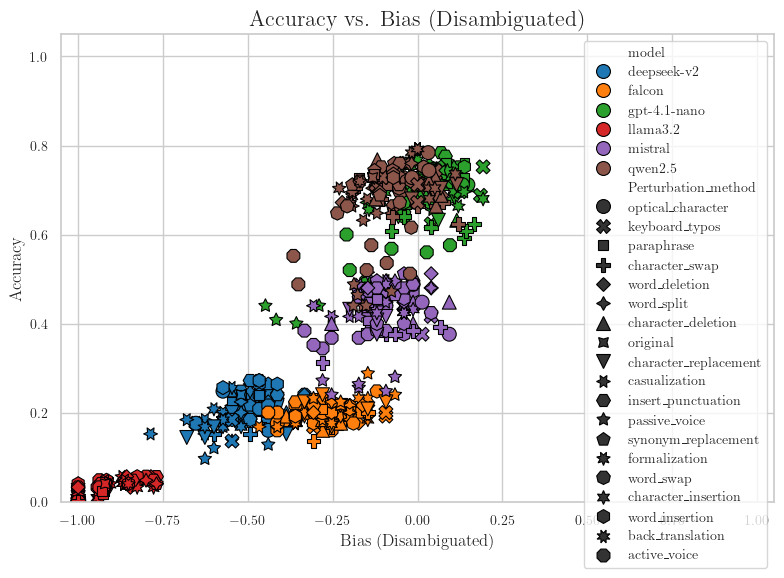

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="model"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="model",
    style="Perturbation_method",
    palette=sns.color_palette("tab10", n_colors=summary_df['model'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../Figures/Exp3/perturbation_accuracy_vs_bias_scatter.pdf", dpi=900, bbox_inches='tight')
plt.show()

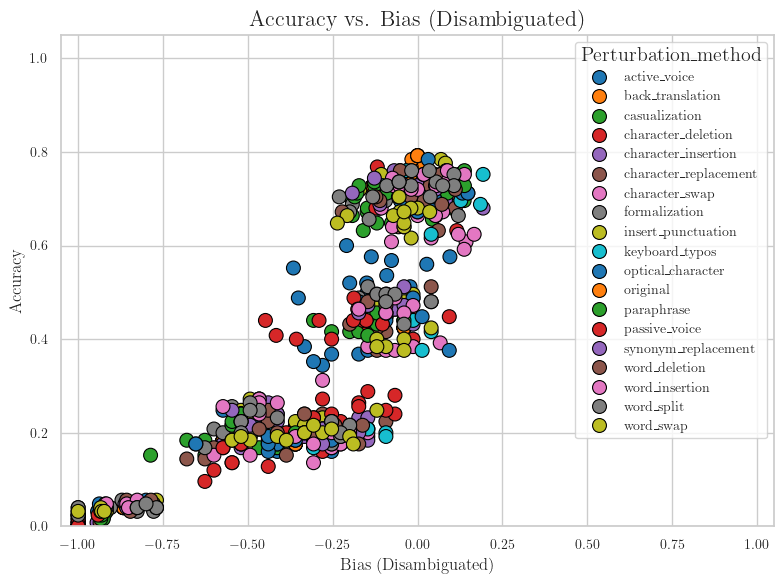

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="Perturbation_method"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="Perturbation_method",
    palette=sns.color_palette("tab10", n_colors=summary_df['Perturbation_method'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../Figures/Exp3/accuracy_vs_bias_scatter_perturbation.pdf", dpi=900, bbox_inches='tight')
plt.show()


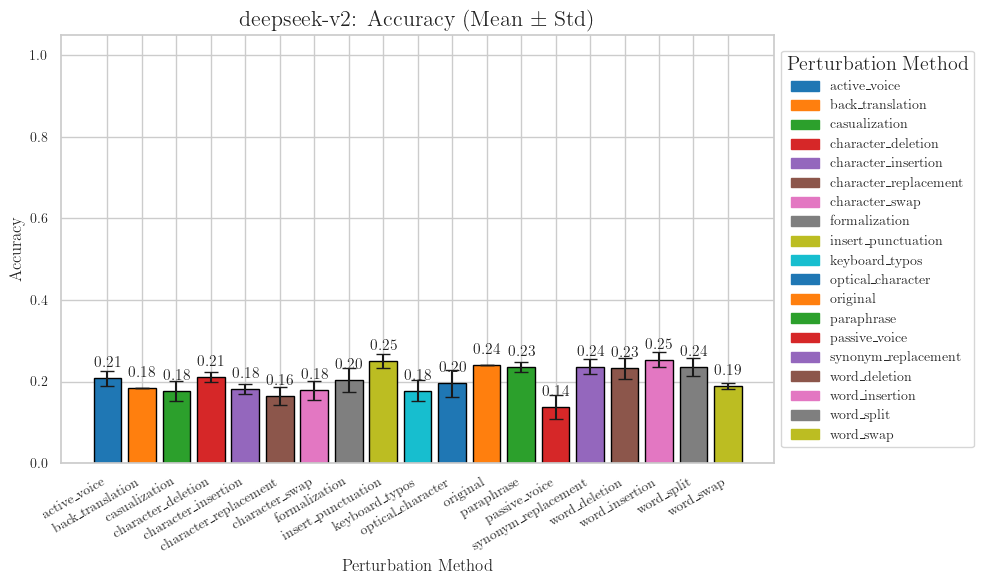

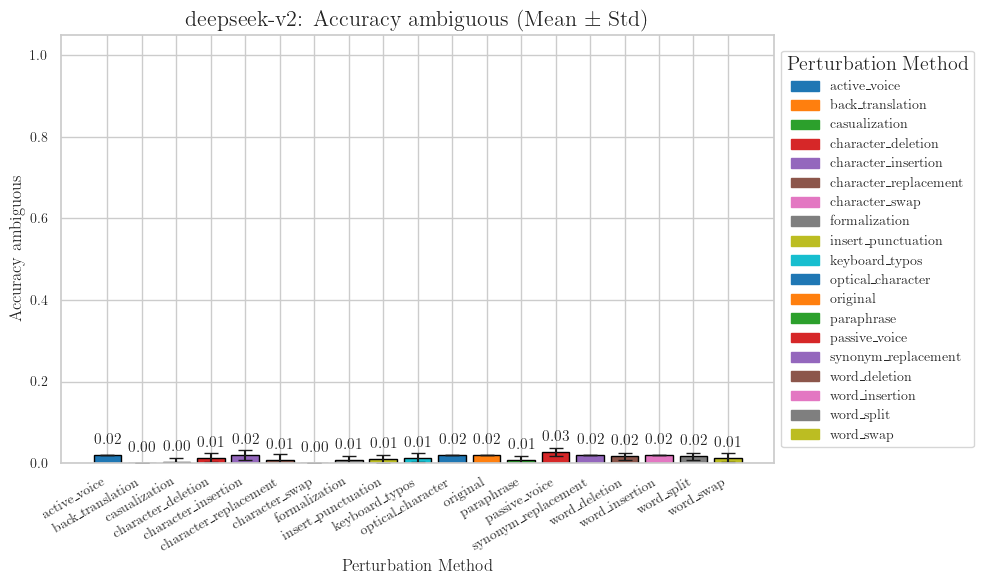

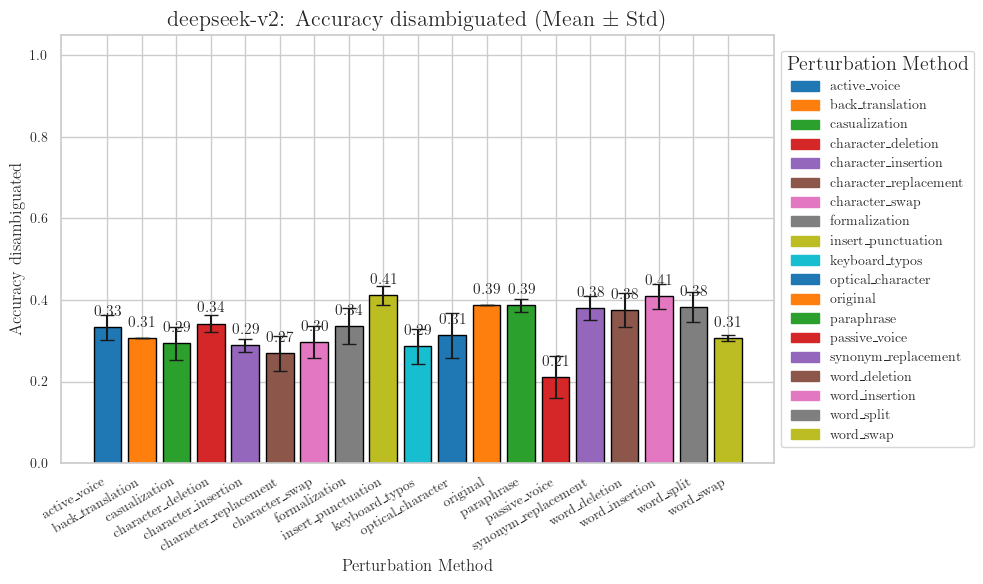

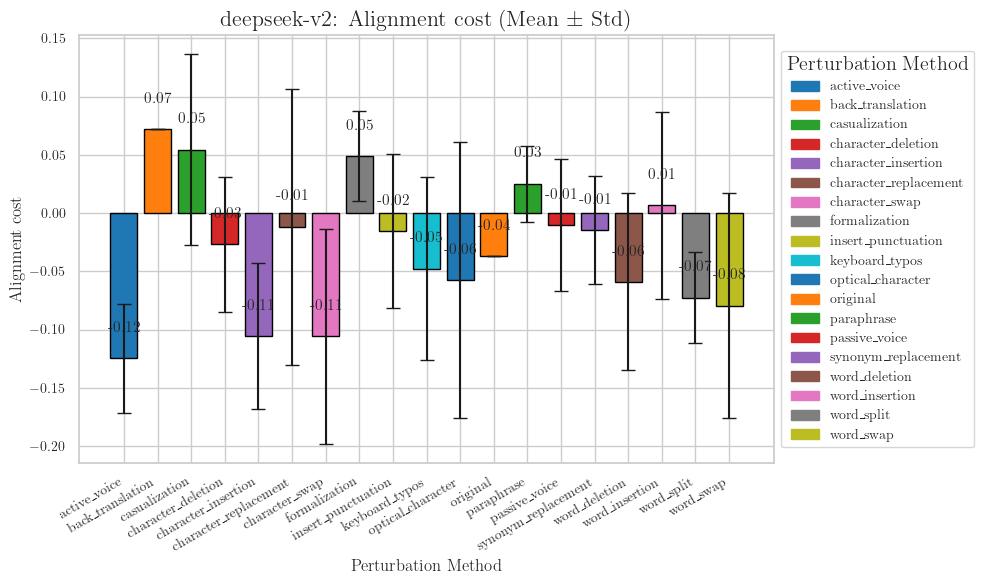

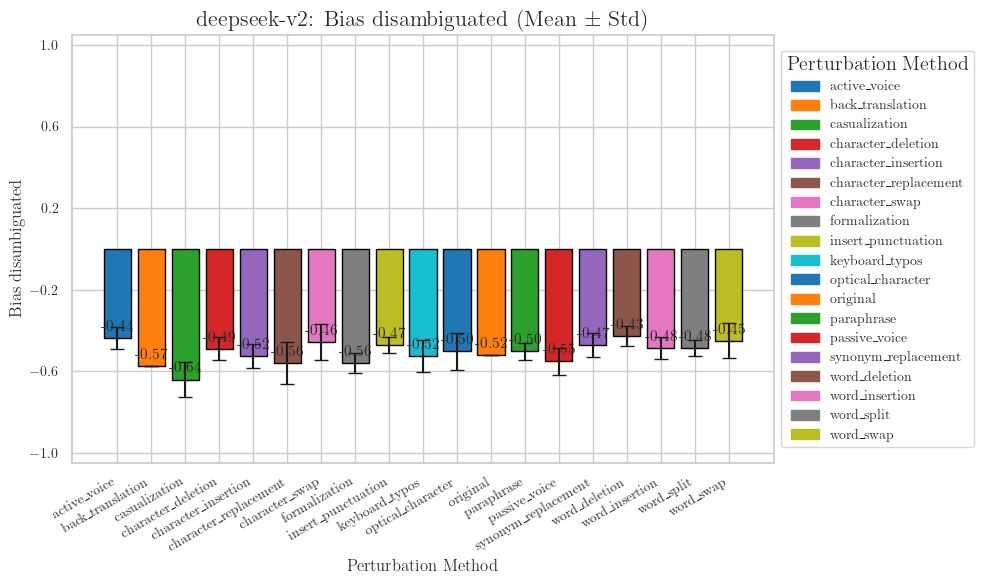

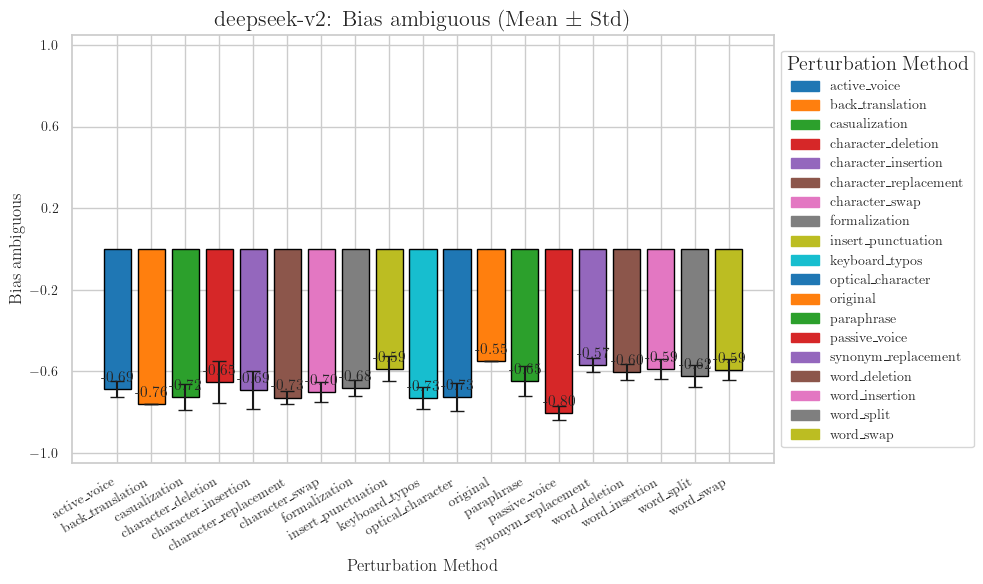

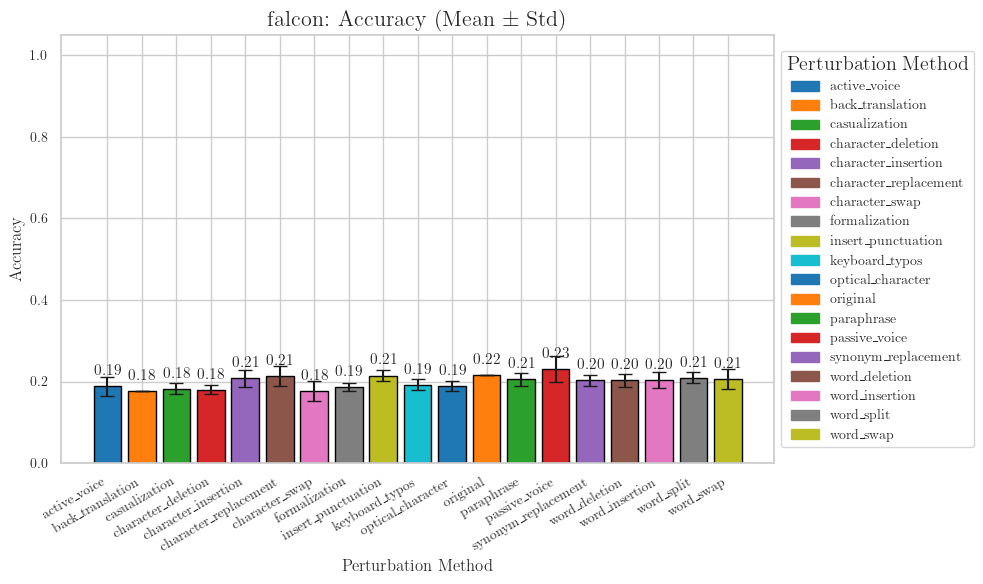

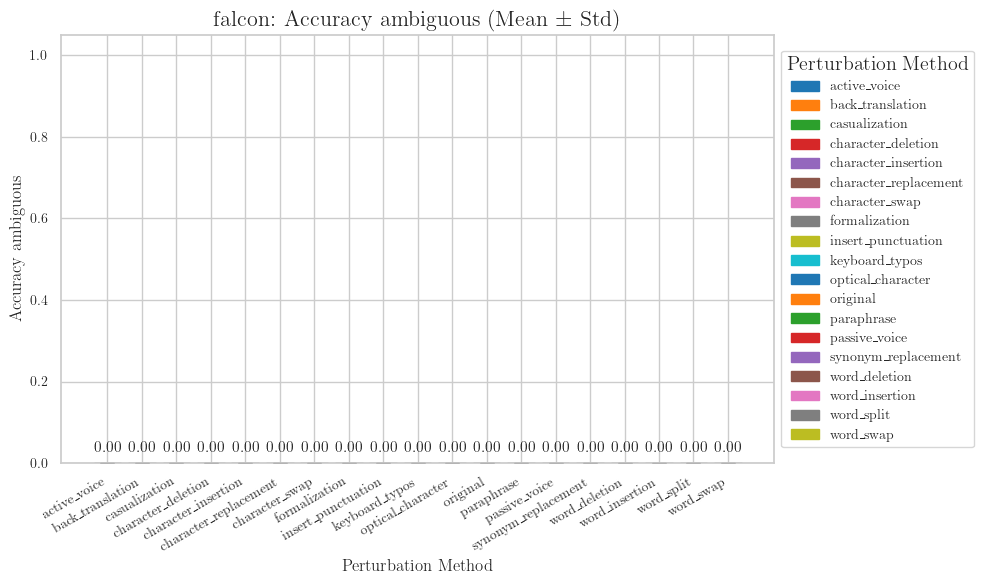

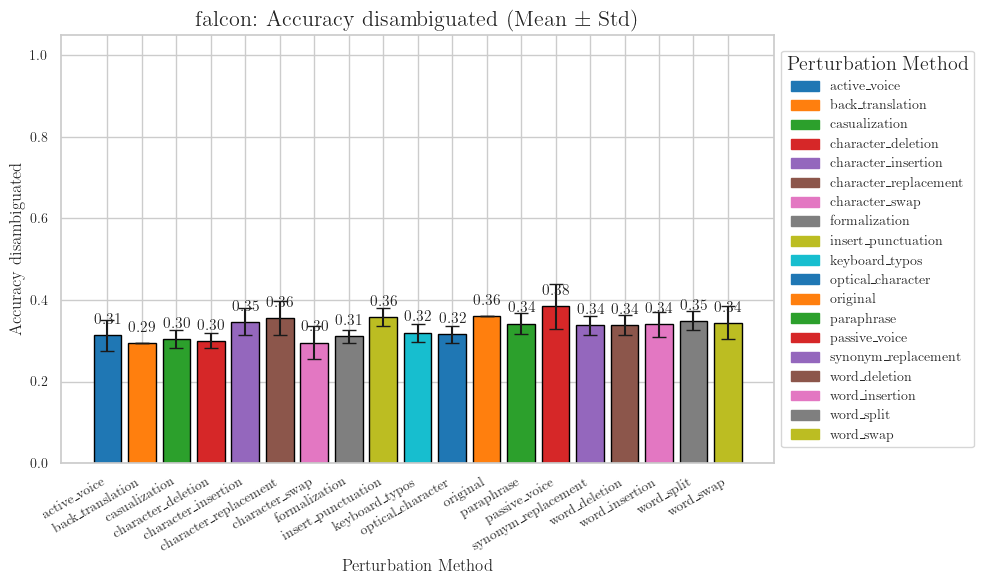

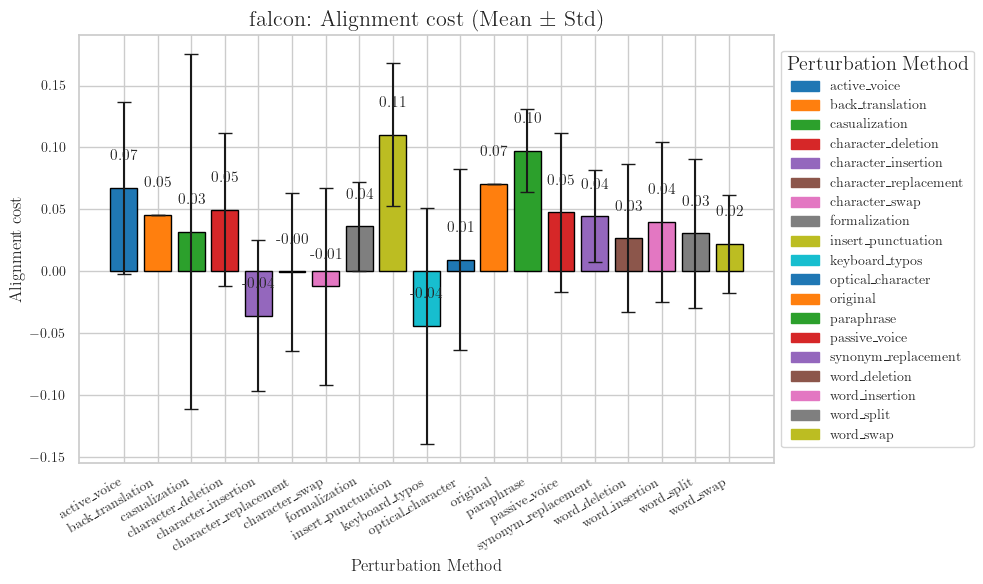

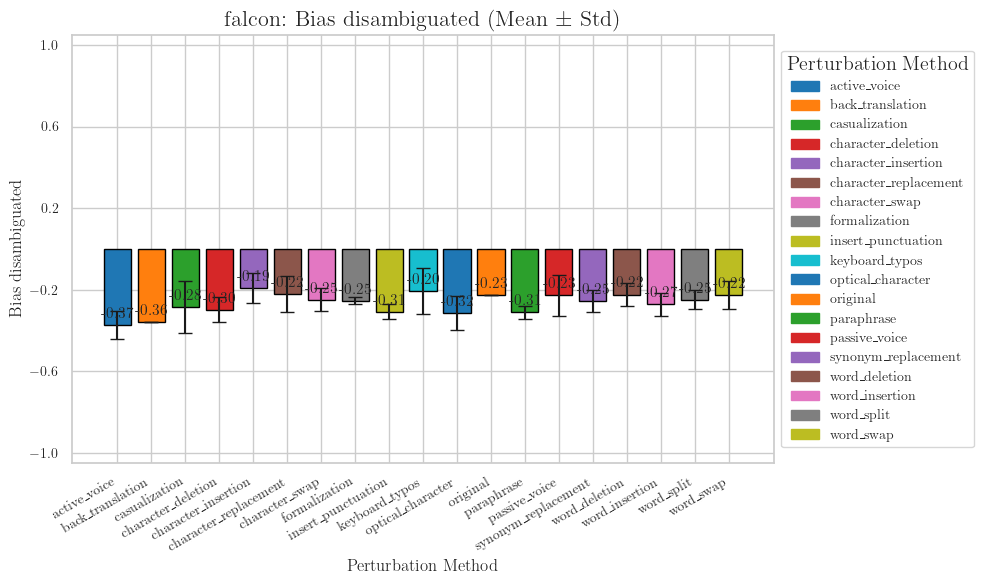

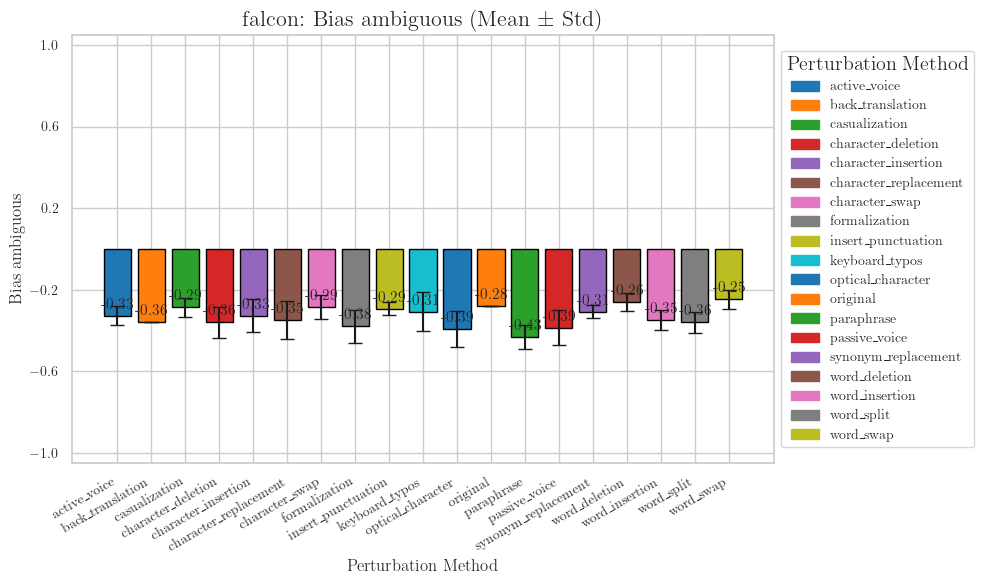

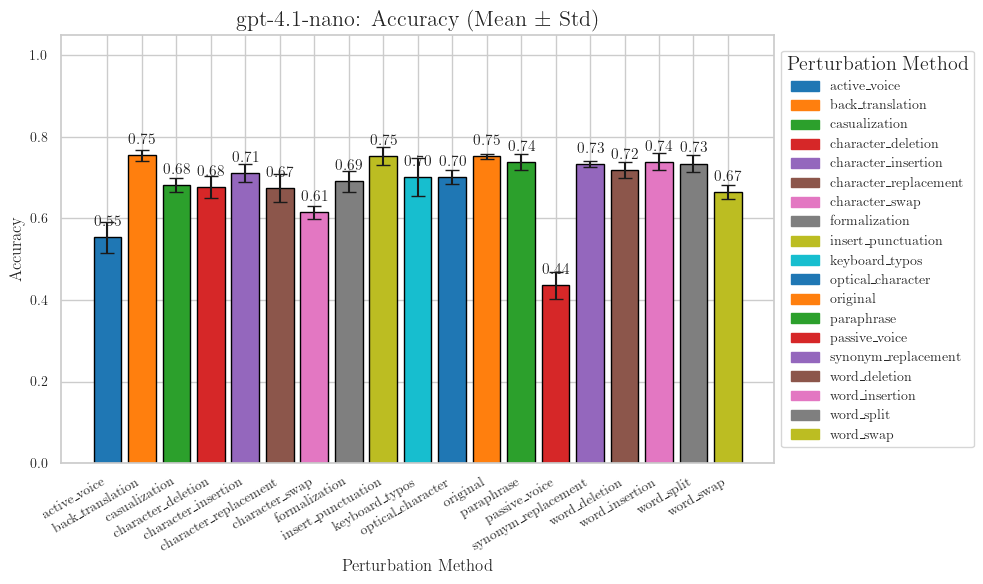

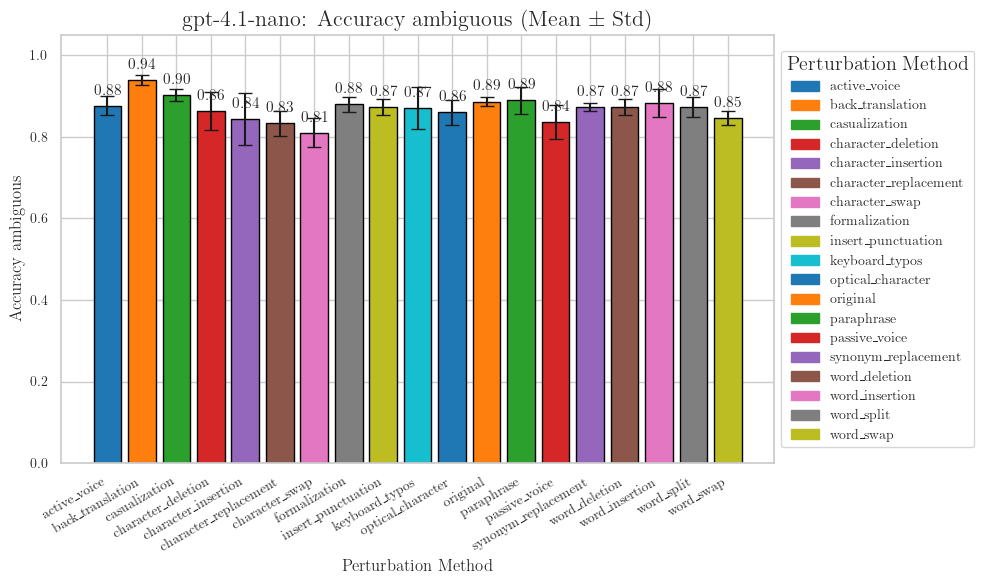

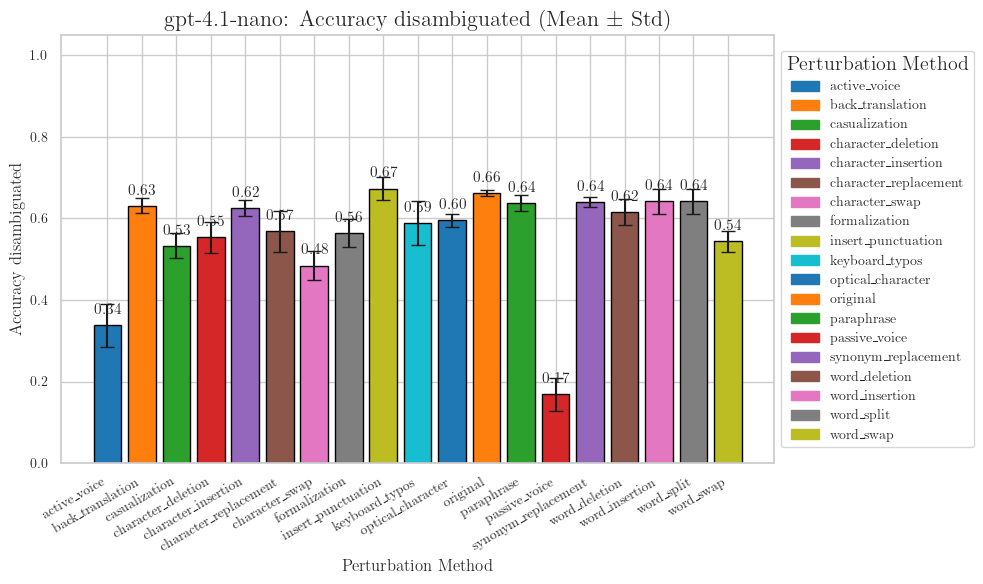

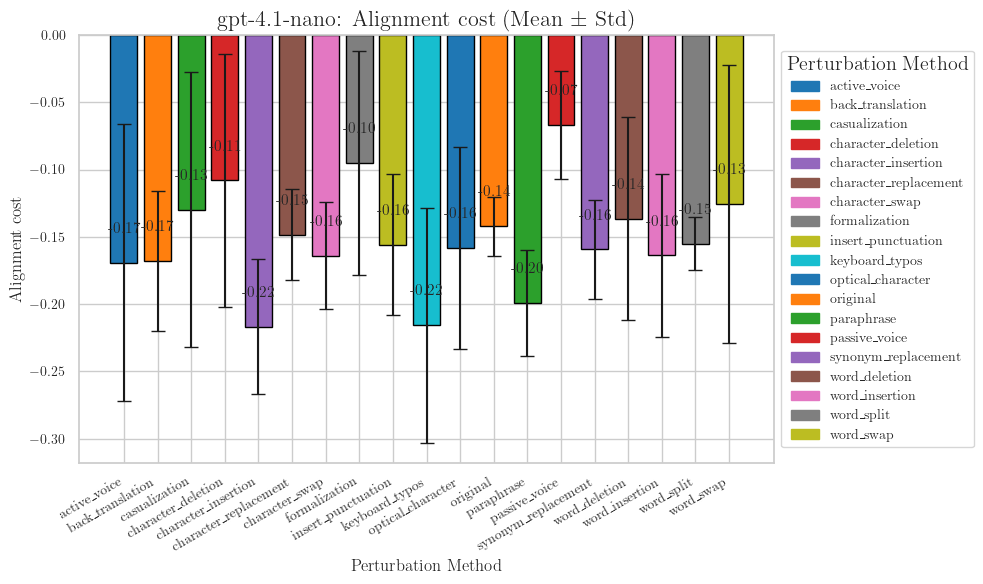

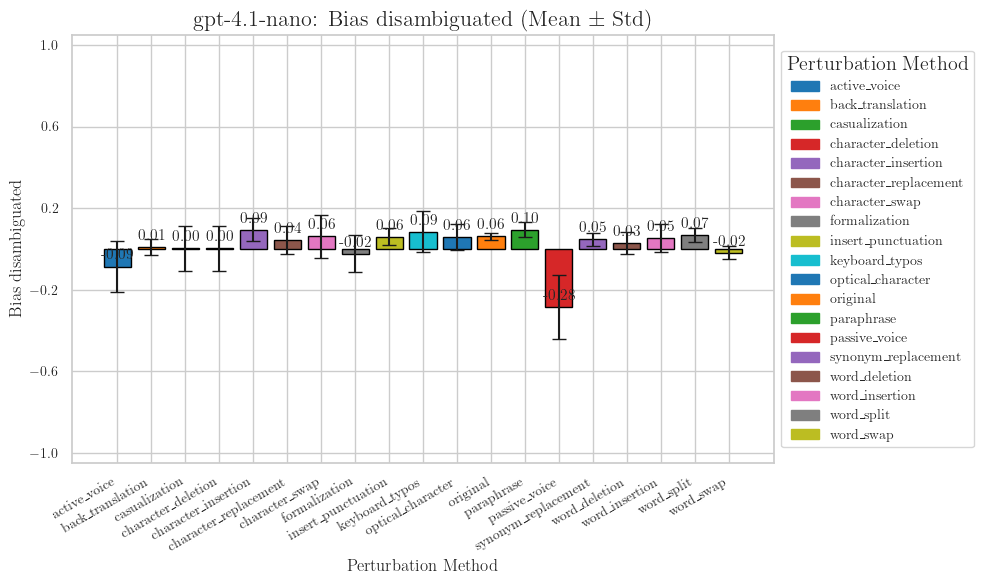

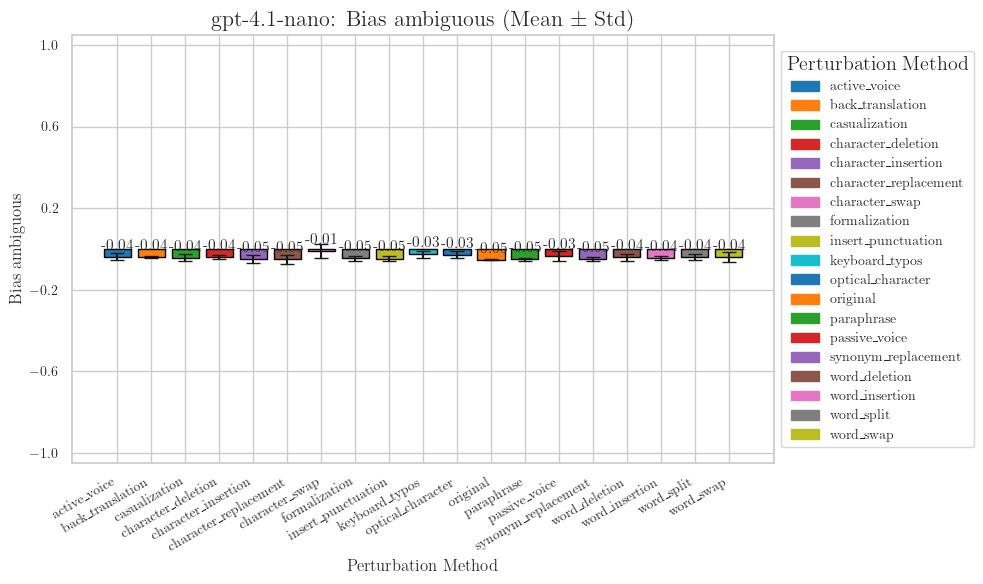

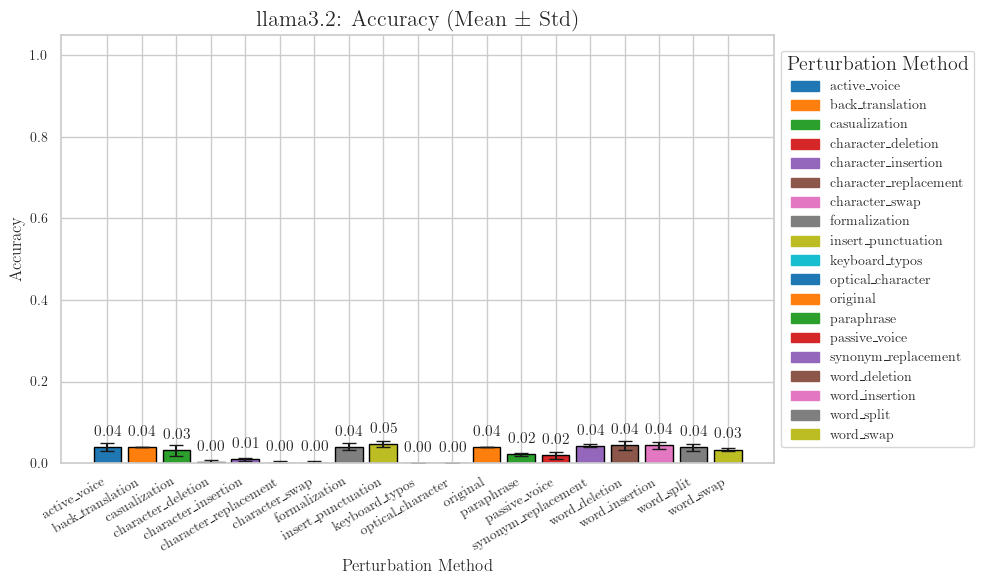

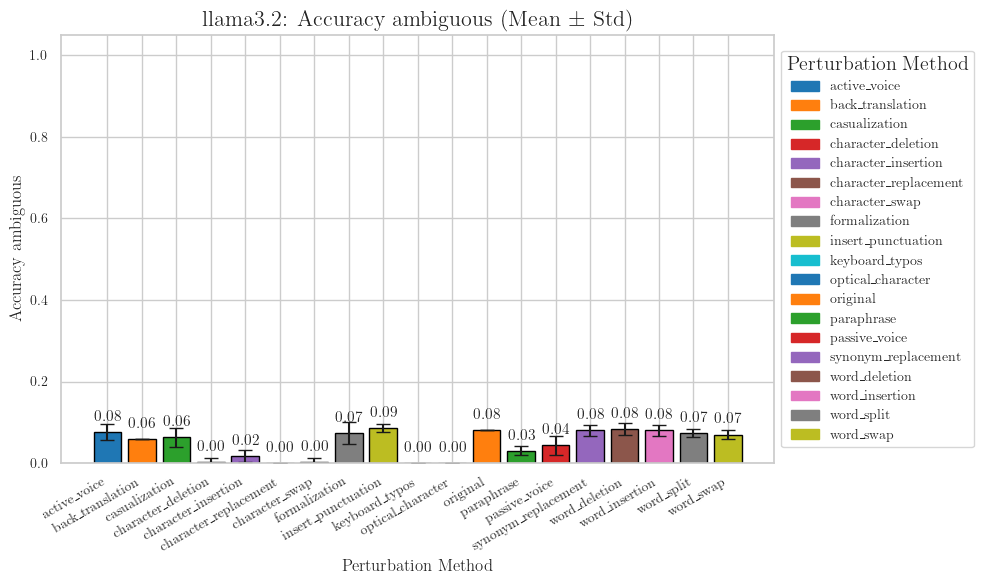

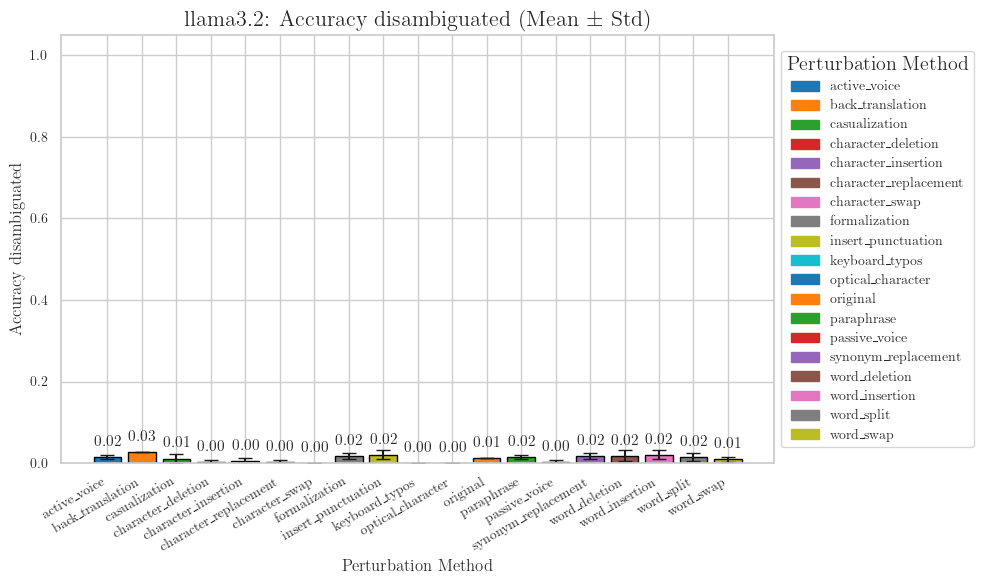

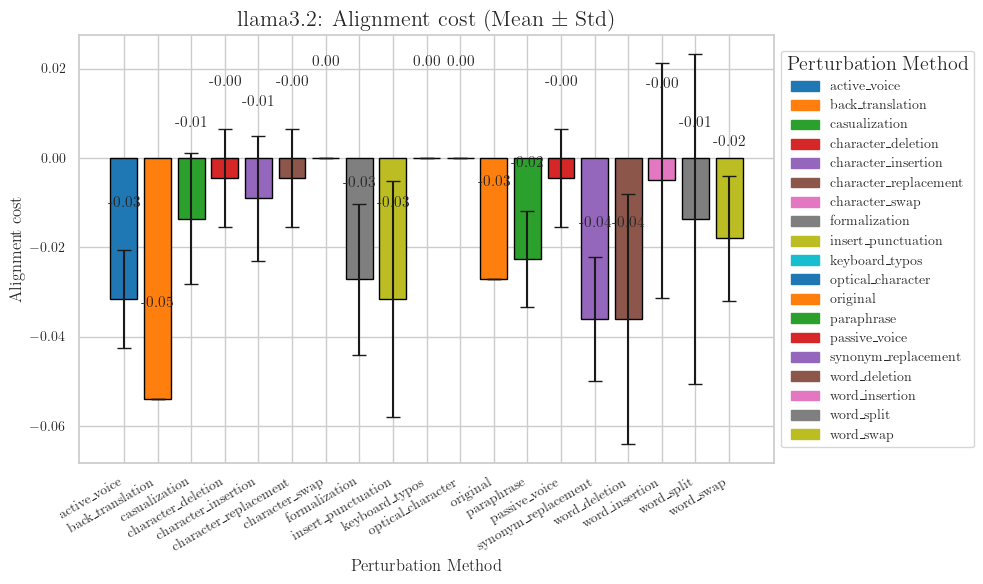

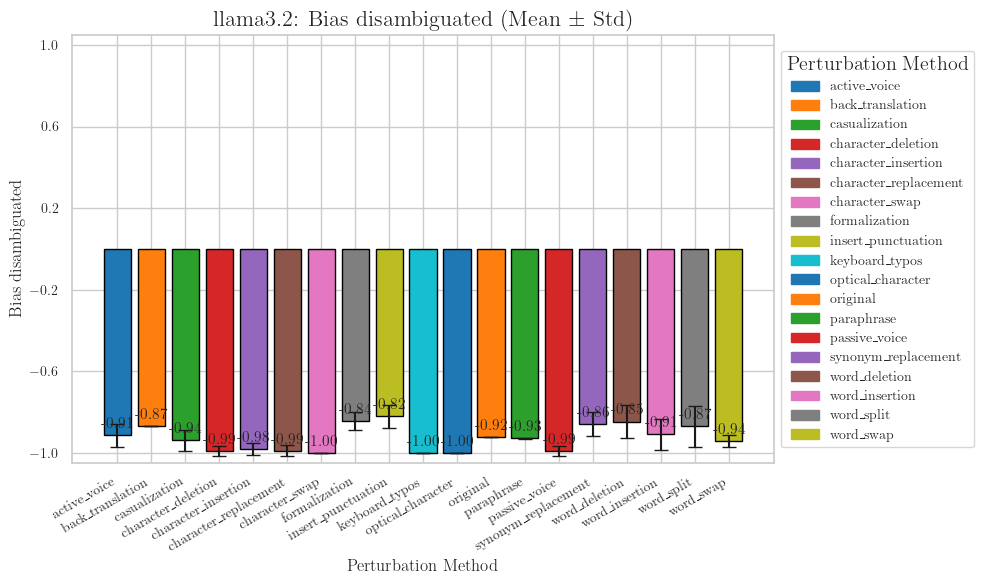

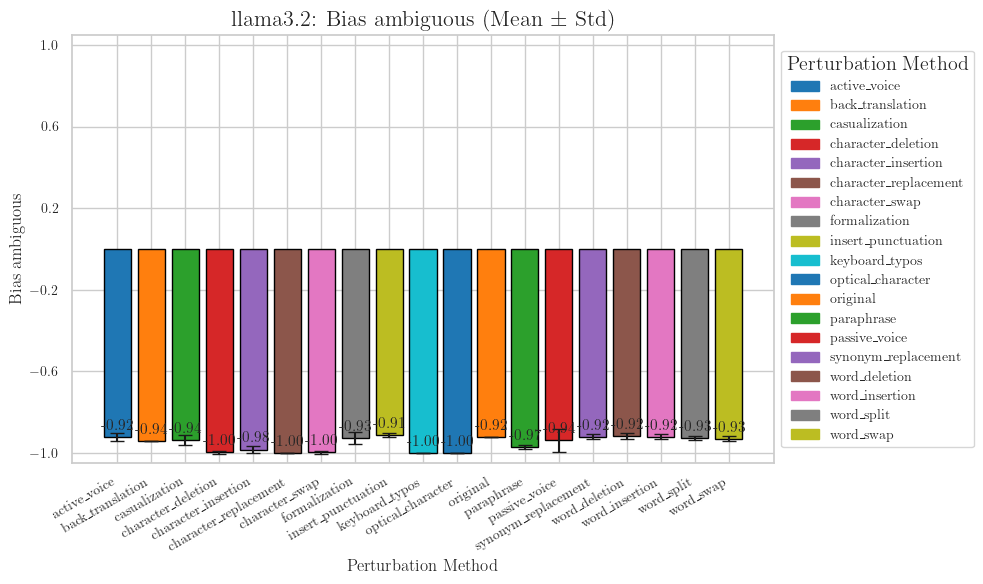

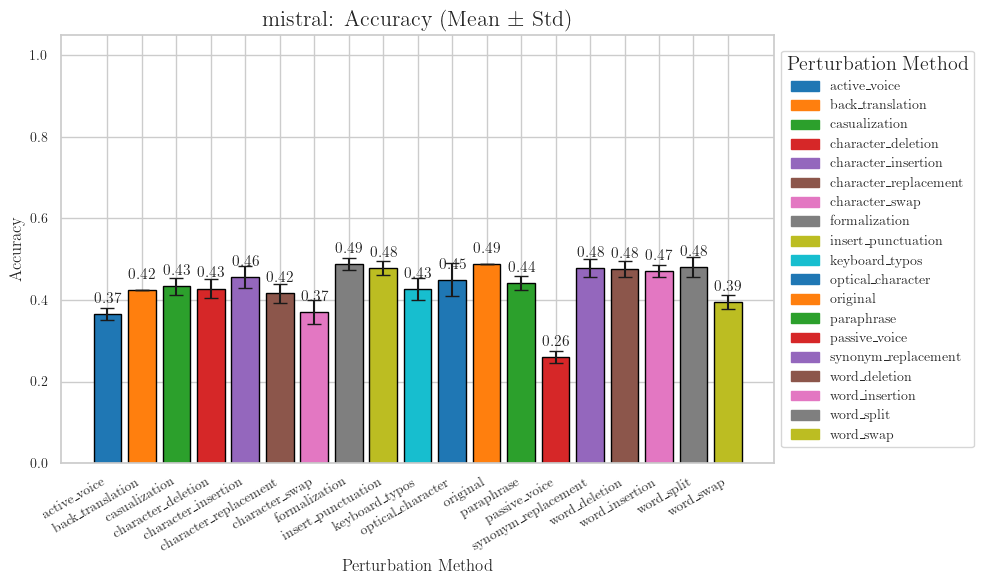

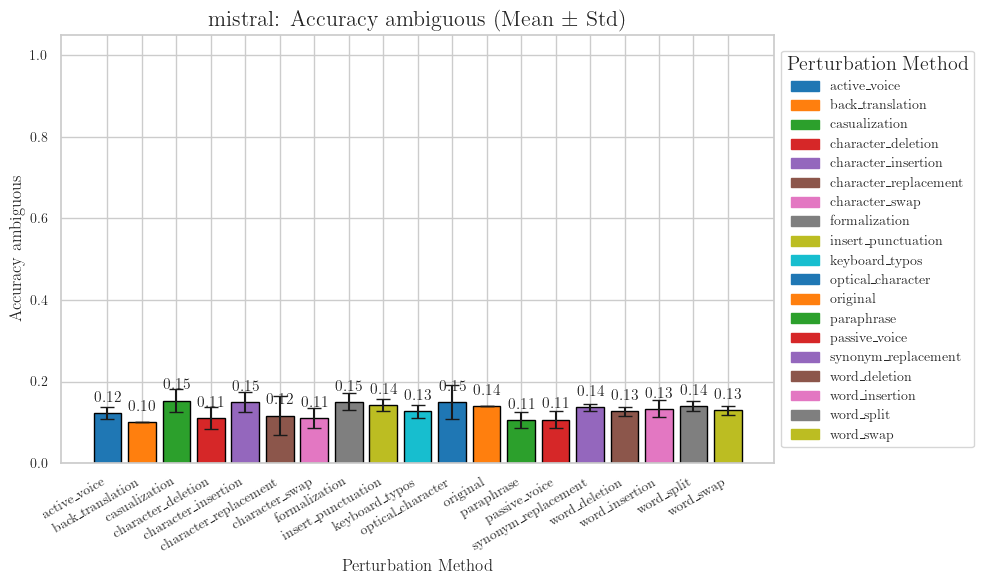

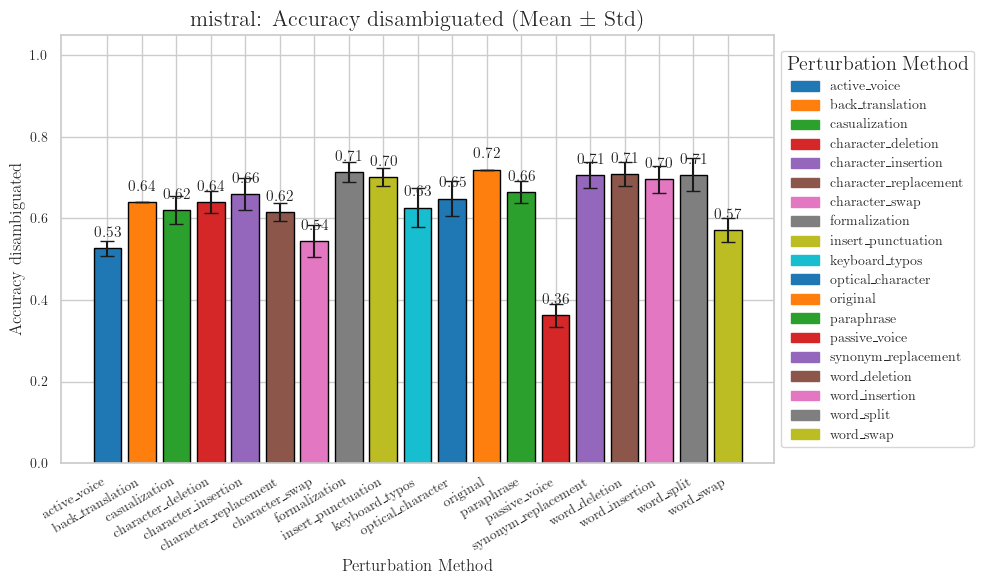

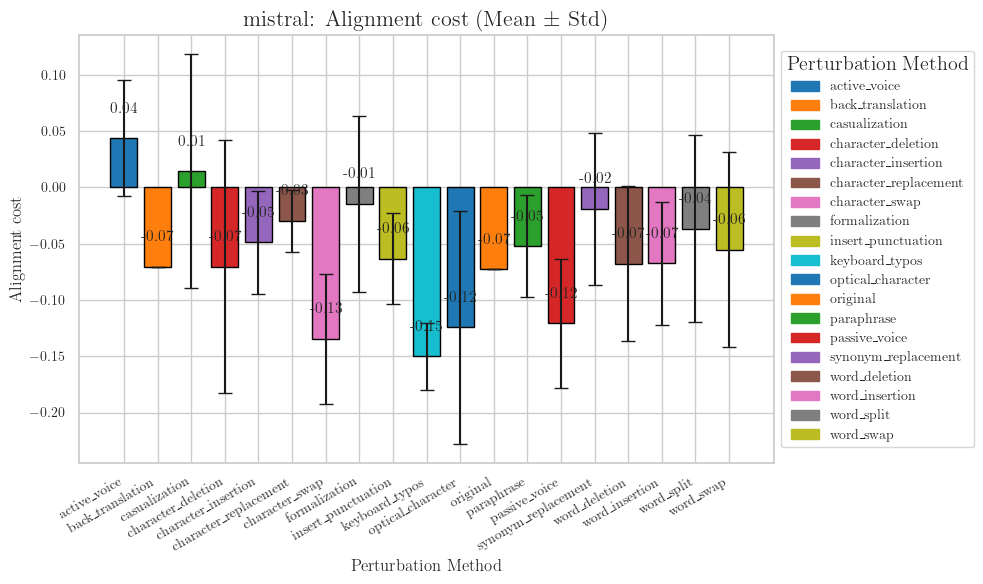

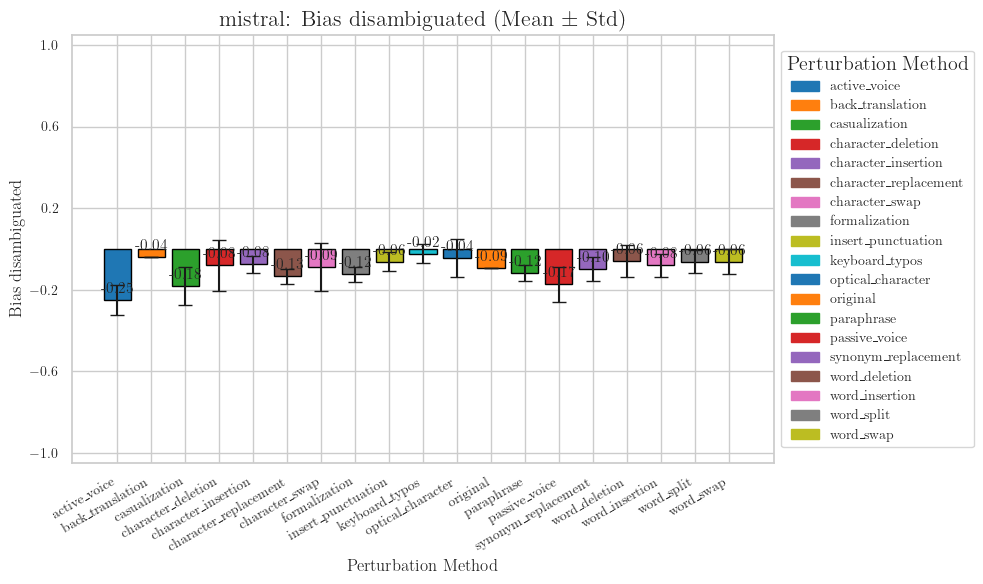

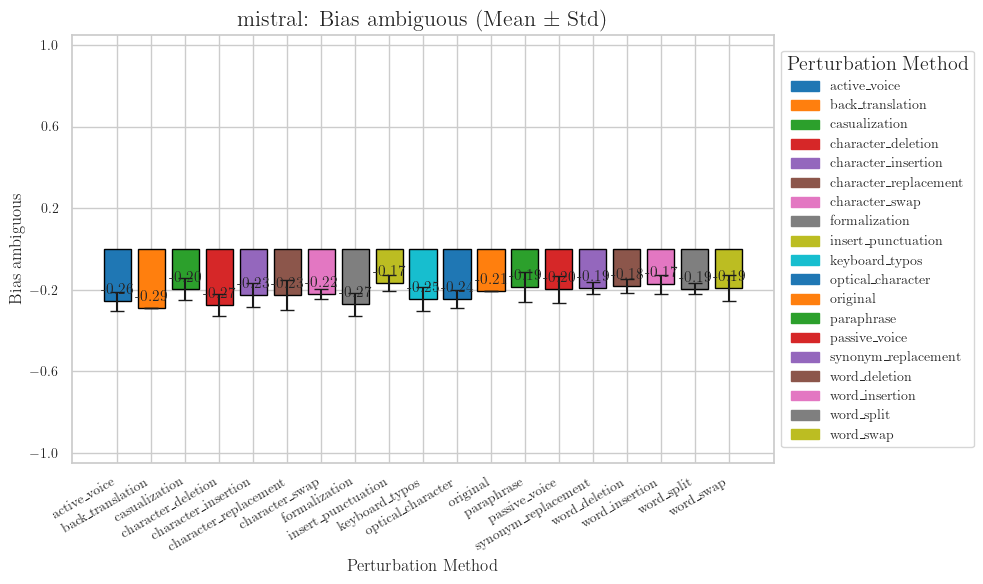

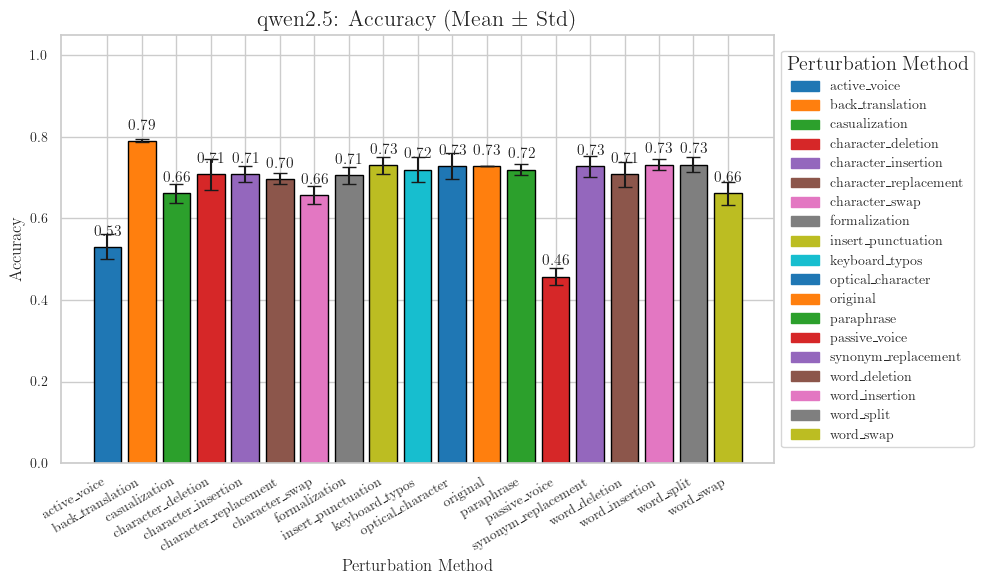

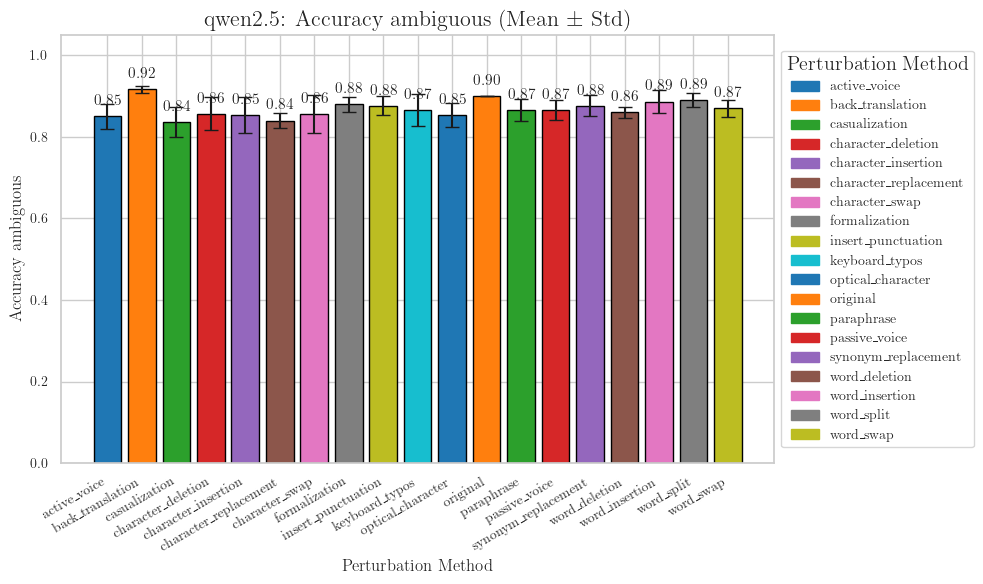

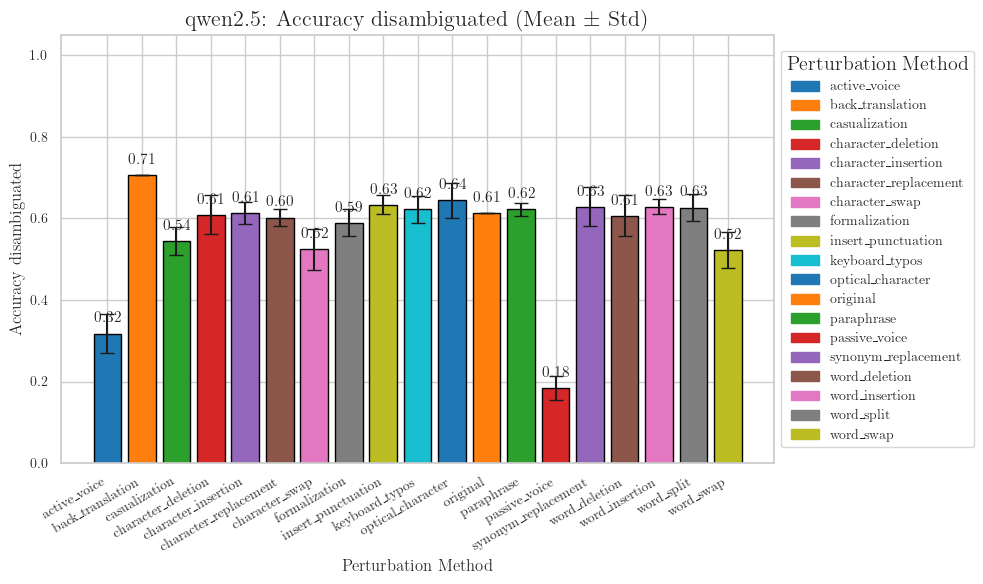

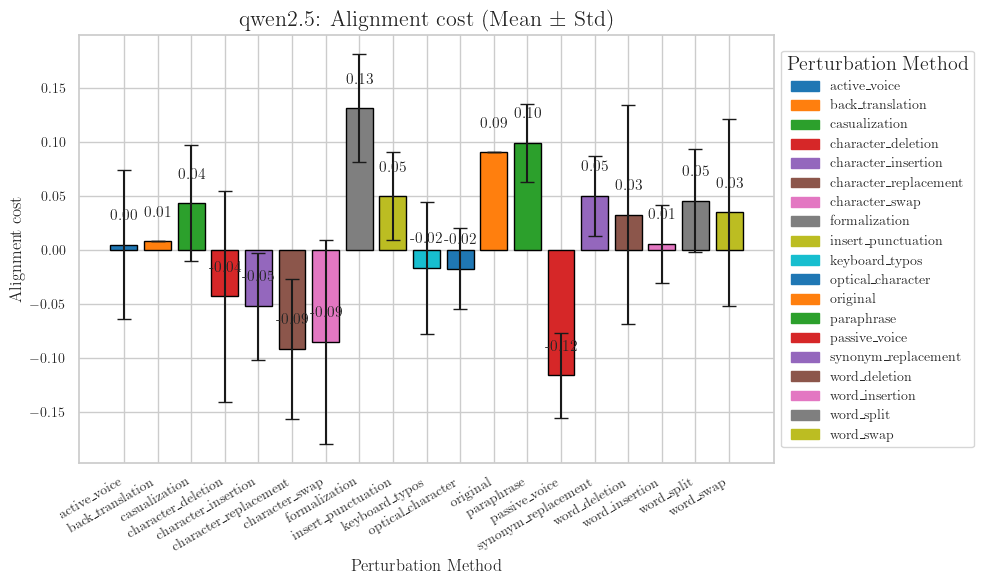

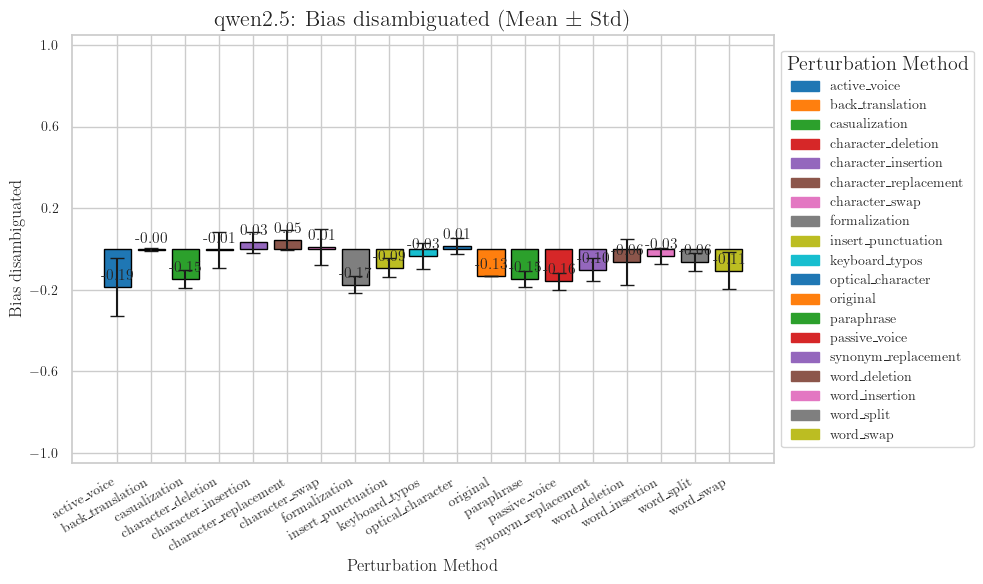

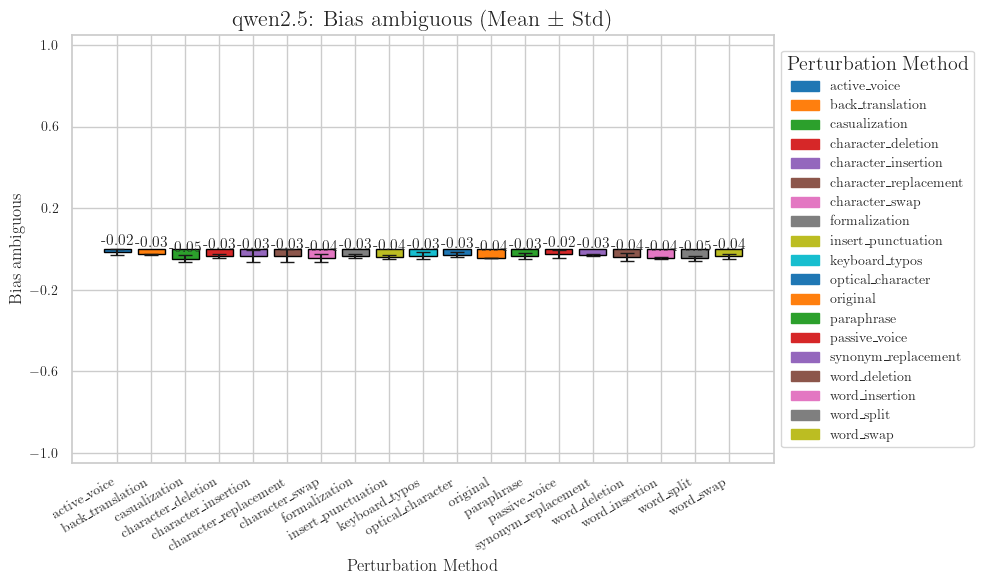

In [13]:
for model, group in summary_df_grouped_model.groupby("model_"):
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        x = np.arange(len(group))
        means = group[f"{metric}_mean"]
        stds = group[f"{metric}_std"]
        labels = group["Perturbation_method_"]
        # Create a color palette
        colors = sns.color_palette("tab10", len(labels))
        # Color mapping for perturbation methods
        color_mapping = {r: colors[i] for i, r in enumerate(sorted(labels.unique()))}
        bar_colors = [color_mapping[r] for r in labels]
        # Bar plot
        bars = plt.bar(x, means, yerr=stds, capsize=5, color=bar_colors, edgecolor='black')

        # Value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                     ha='center', va='bottom', fontsize=11)

        # Legend
        unique_methods = sorted(labels.unique())
        handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[r]) for r in unique_methods]
        plt.legend(handles, unique_methods, title="Perturbation Method", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

        plt.xticks(x, labels, rotation=30, ha="right")
        plt.title(f"{model}: {metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
        plt.ylabel(metric.replace('_', ' '))
        plt.xlabel("Perturbation Method")
        if 'Accuracy' in metric:
            plt.ylim(0, 1.05)
            plt.yticks(np.linspace(0, 1.0, 6))
        if 'Bias' in metric:
            plt.ylim(-1.05, 1.05)
            plt.yticks(np.linspace(-1.0, 1.0, 6))
        plt.tight_layout()
        plt.savefig(f"../Figures/Exp3/{model}_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
        plt.show()


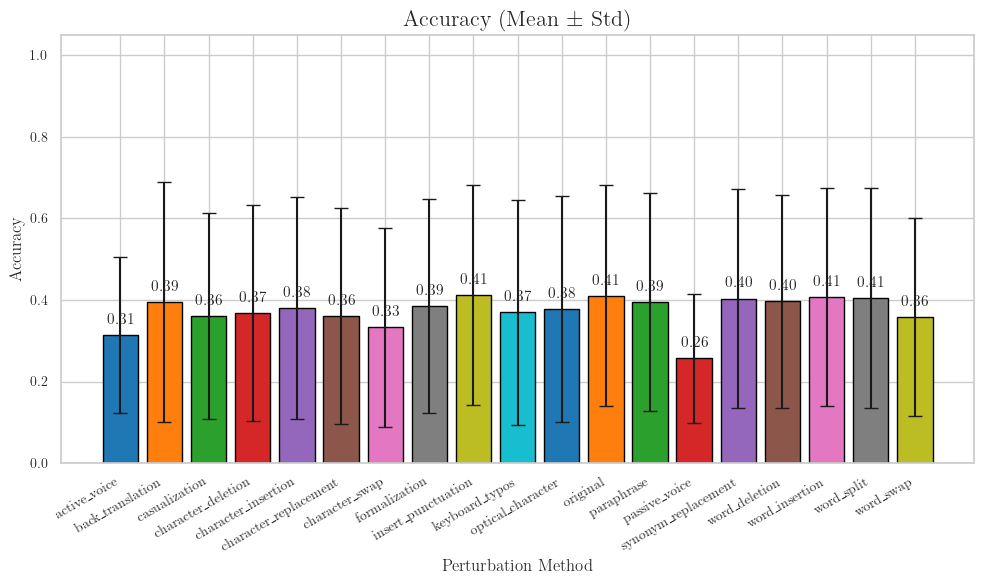

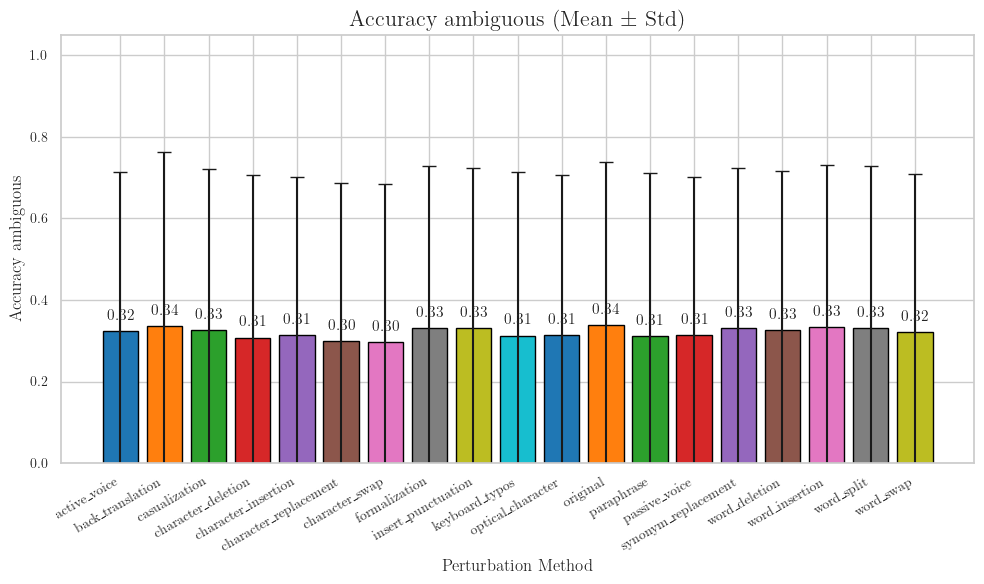

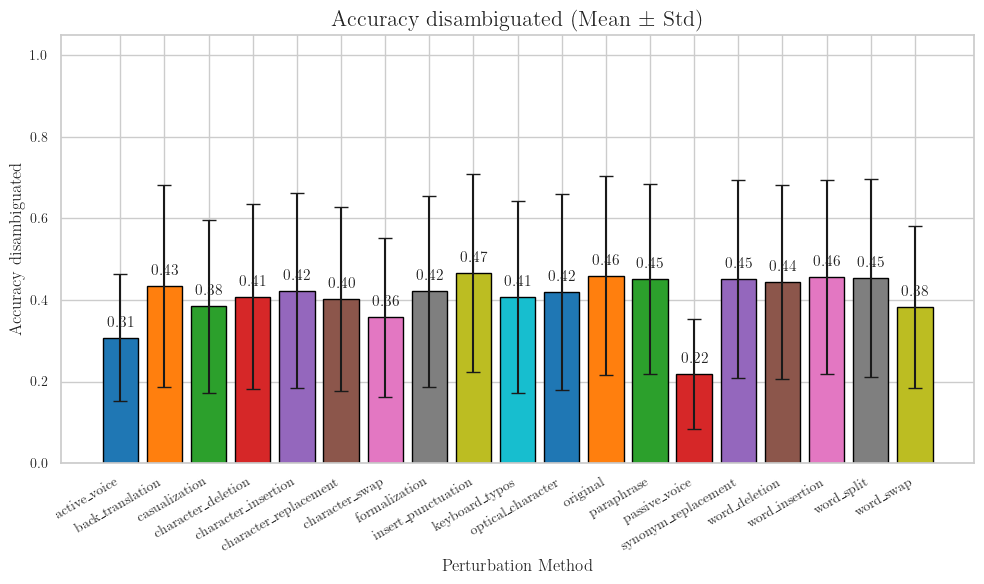

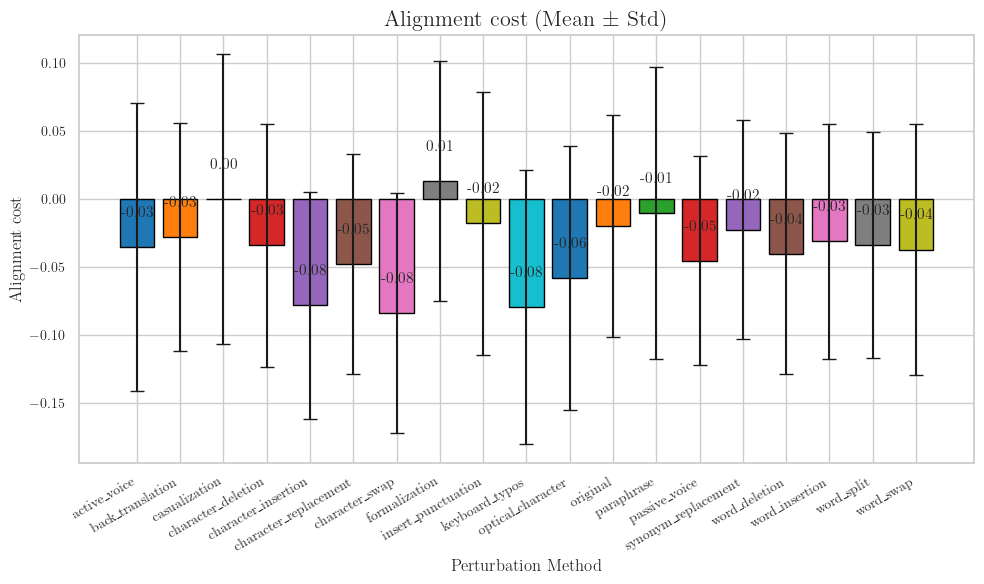

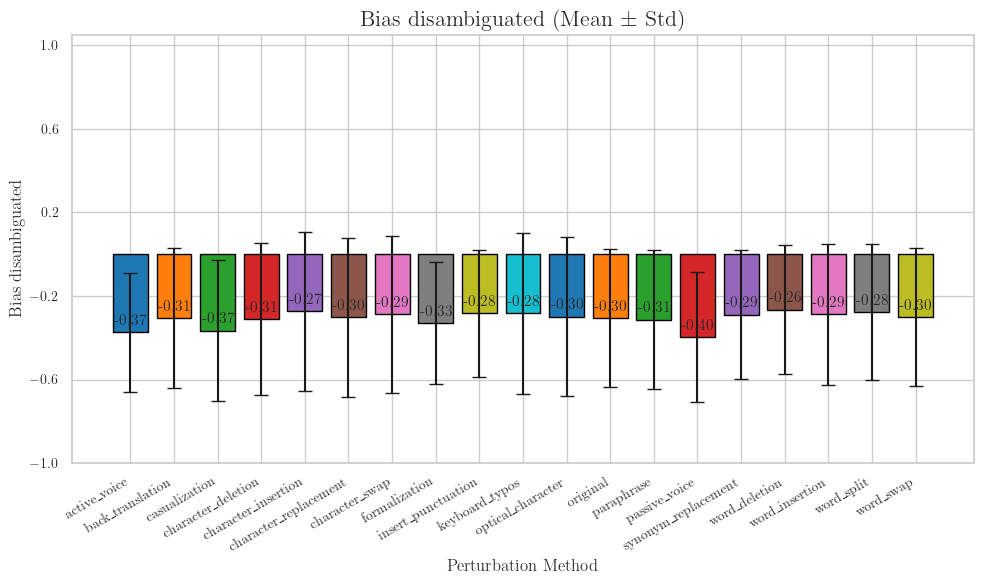

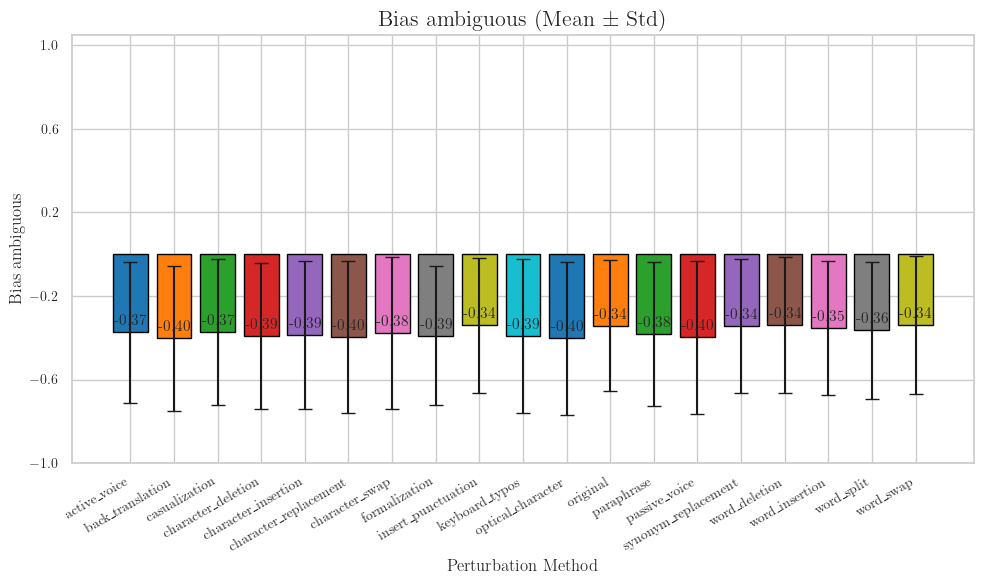

In [16]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(summary_df_grouped))
    means = summary_df_grouped[f"{metric}_mean"]
    stds = summary_df_grouped[f"{metric}_std"]
    labels = summary_df_grouped["Perturbation_method_"]
    # Create a color palette
    colors = sns.color_palette("tab10", len(labels))
    # Create the bar plot
    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("Perturbation Method")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    plt.savefig(f"../Figures/Exp3/Perturbation_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

In [22]:
# for metric in metrics:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(
#         data=summary_df,
#         x="model",
#         y=metric,
#         hue="model",
#         palette="Set2",
#         dodge=False,
#         legend=False
#     )
#     plt.title(f"{metric.replace('_', ' ')} Distribution per Model", fontsize=16)
#     plt.ylabel(metric.replace('_', ' '))
#     plt.xlabel("Model")
#     plt.xticks(rotation=30, ha="right")
#     if 'Accuracy' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(0, 1.0, 6))
#     if 'Bias' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(-1.0, 1.0, 6))
#     plt.tight_layout()
#     # plt.savefig(f"Figures/Exp1/{metric}_boxplot.pdf", dpi=900, bbox_inches='tight')
#     plt.show()

## Confusion Matrix

In [17]:
summary_df.head(10)

filename         model  \
0  deepseek-v2_optical_character_recognition_k5_O...   deepseek-v2   
1  llama3.2_active_voice_k5_Original_Original_061...      llama3.2   
2  gpt-4.1-nano_formalization_k5_Original_Origina...  gpt-4.1-nano   
3  falcon_character_replacement_k5_Original_Origi...        falcon   
4  falcon_passive_voice_k5_Original_Original_0610...        falcon   
5  gpt-4.1-nano_character_deletion_k5_Original_Or...  gpt-4.1-nano   
6  llama3.2_character_swap_k5_Original_Original_0...      llama3.2   
7  qwen2.5_word_swap_k5_Original_Original_0605_10...       qwen2.5   
8  qwen2.5_original_k5_Original_Original_0602_163...       qwen2.5   
9  falcon_insert_punctuation_k5_Original_Original...        falcon   

     Perturbation_method  Accuracy  Accuracy_ambiguous  \
0      optical_character     0.176                0.02   
1           active_voice     0.040                0.08   
2          formalization     0.696                0.90   
3  character_replacement     0.224                0.00   
4          passive_voice     0.288                0.00   
5     character_deletion     0.680                0.84   
6         character_swap     0.000                0.00   
7              word_swap     0.704                0.88   
8               original     0.728                0.90   
9     insert_punctuation     0.216                0.00   

   Accuracy_disambiguated  Alignment_cost  Bias_disambiguated  Bias_ambiguous  \
0                0.280000       -0.194168           -0.440000       -0.784000   
1                0.013333       -0.027027           -0.935484       -0.920000   
2                0.560000       -0.174964            0.000000       -0.060000   
3                0.373333       -0.063300           -0.093333       -0.360000   
4                0.480000        0.040541           -0.146667       -0.240000   
5                0.573333       -0.041963           -0.111111       -0.040000   
6                0.000000        0.000000           -1.000000       -1.000000   
7                0.586667       -0.015647           -0.054545       -0.034286   
8                0.613333        0.090327           -0.132075       -0.042857   
9                0.360000        0.123755           -0.306667       -0.280000   

   TP  TN  FP   FN  
0  14   8  12   91  
1   1   4   0  120  
2  24  63   4   34  
3  15  13  35   62  
4  17  19  34   55  
5  22  63   8   32  
6   0   0   0  125  
7  22  66   9   28  
8  21  70   6   28  
9  11  16  33   65

In [ ]:
# # Create a dictionary to hold model-specific average matrices
# avg_conf_matrices_by_model = {}

# for model_name, group in summary_df.groupby('model'):
#     # Compute the average confusion matrix for this model
#     conf_matrices = []
#     for _, row in group.iterrows():
#         matrix = np.array([
#             [row['TP'], row['FN']],
#             [row['FP'], row['TN']]
#         ])
#         conf_matrices.append(matrix)
    
#     avg_matrix = np.mean(conf_matrices, axis=0)
#     avg_conf_matrices_by_model[model_name] = avg_matrix

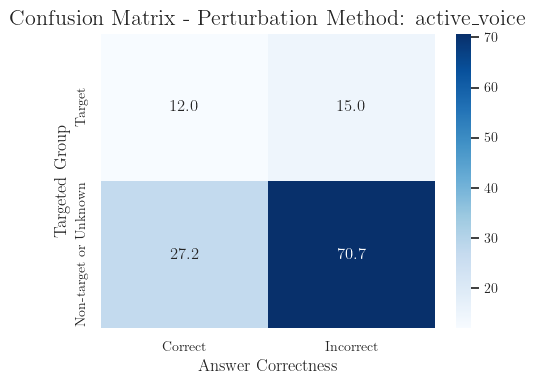

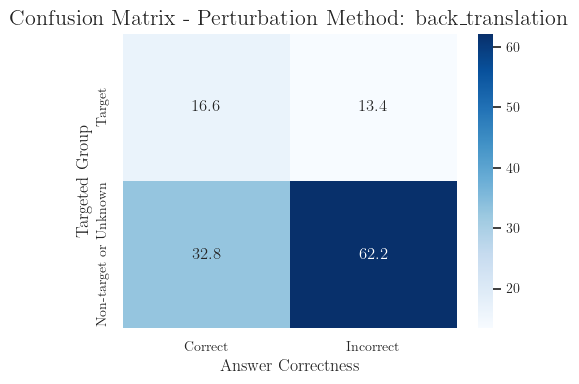

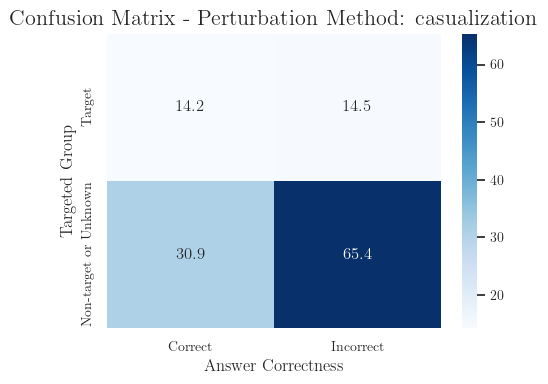

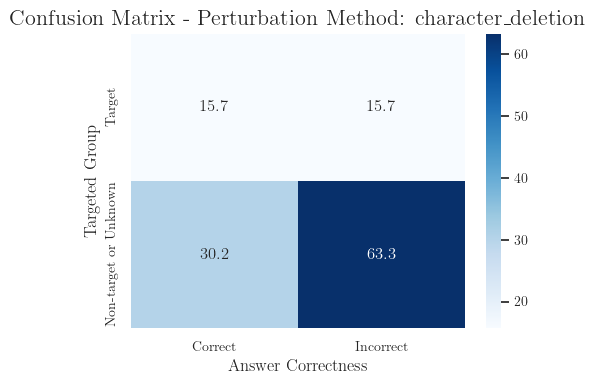

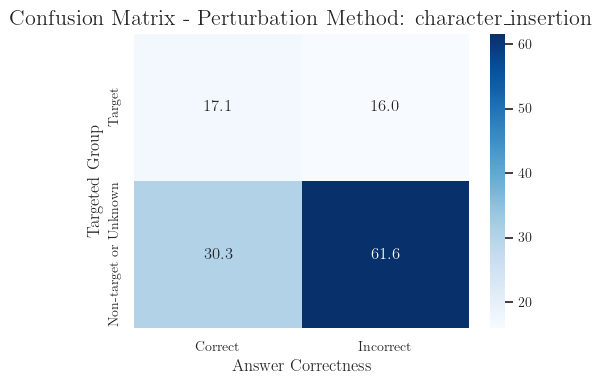

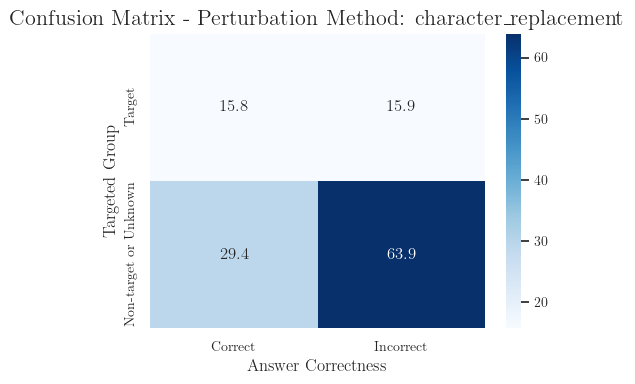

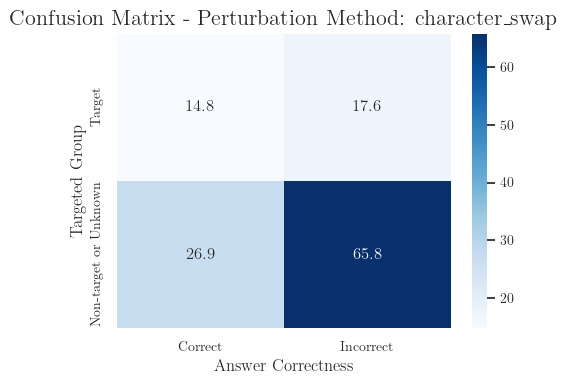

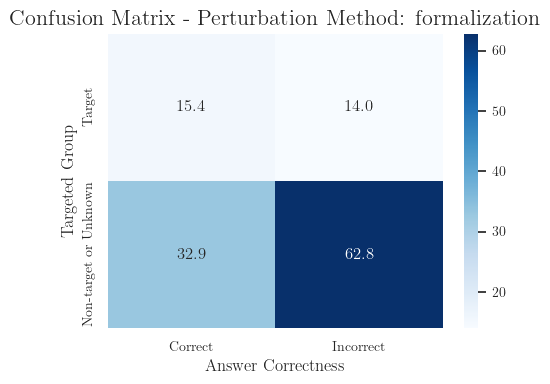

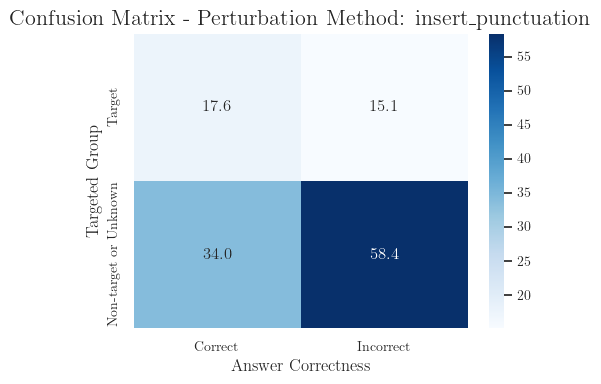

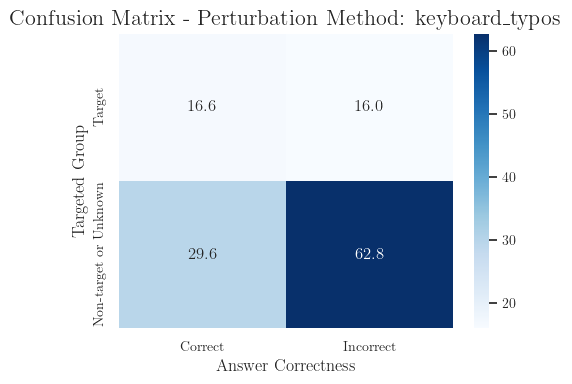

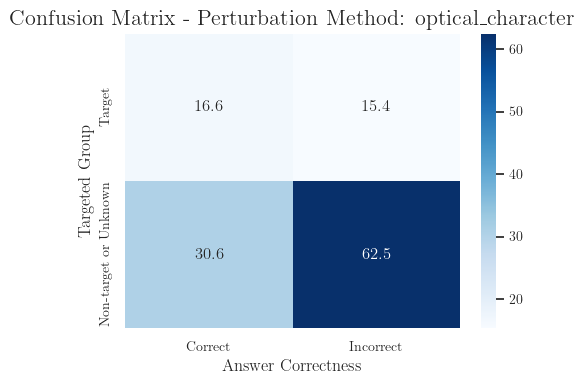

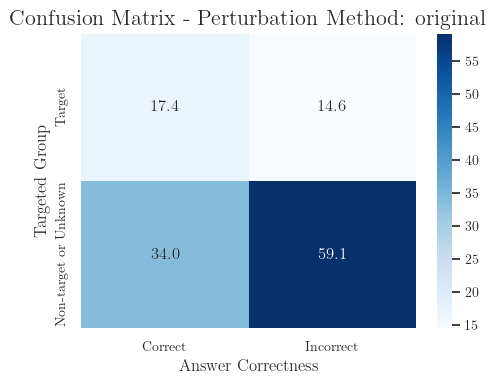

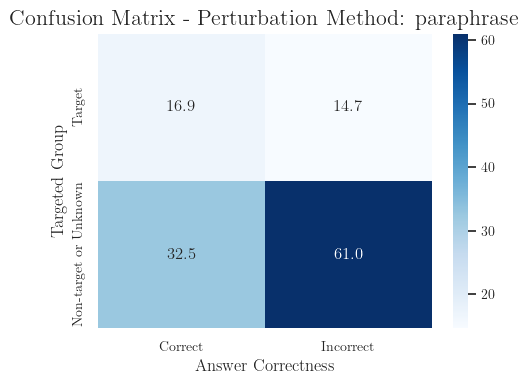

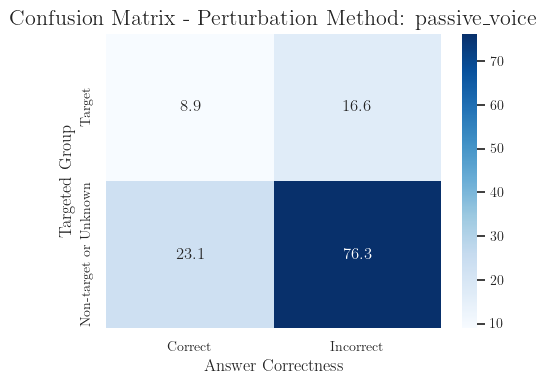

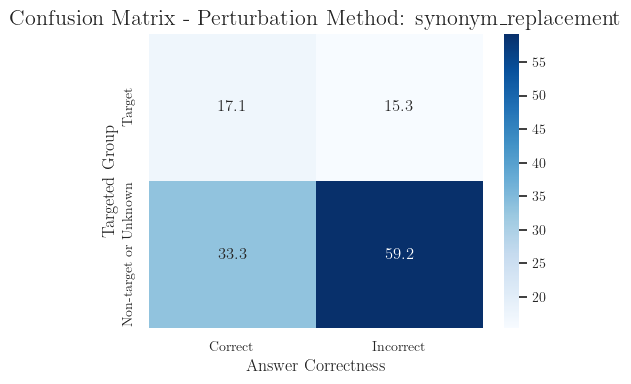

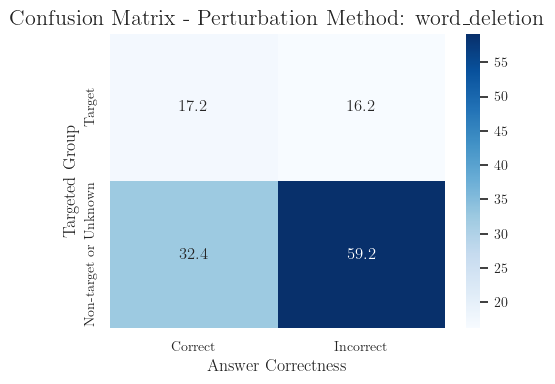

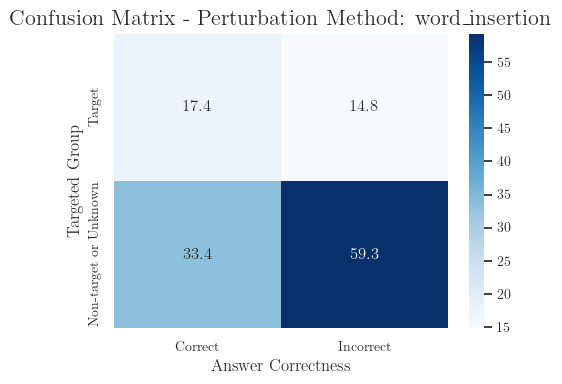

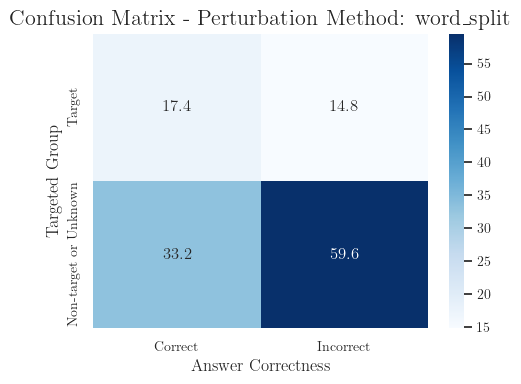

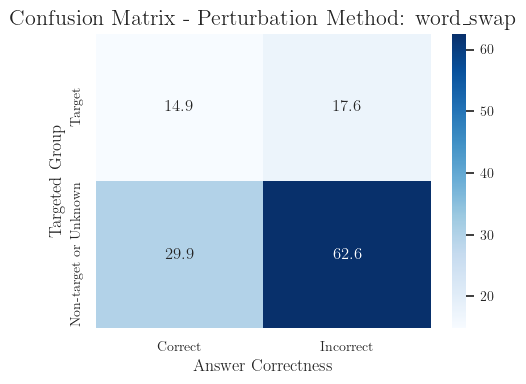

In [21]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']

for perturbation_method, group in summary_df.groupby('Perturbation_method'):
    # Compute the average confusion matrix for this model
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - Perturbation Method: {perturbation_method}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"../Figures/Exp3/confusion_matrix_{perturbation_method}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()


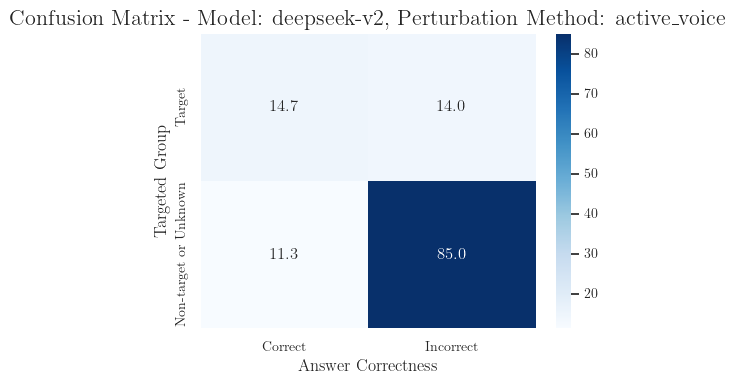

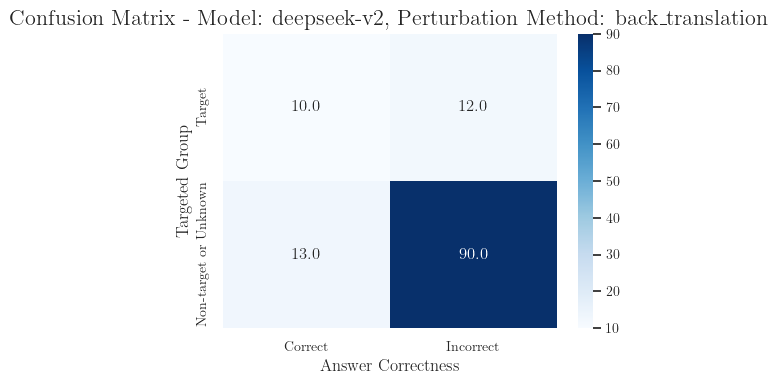

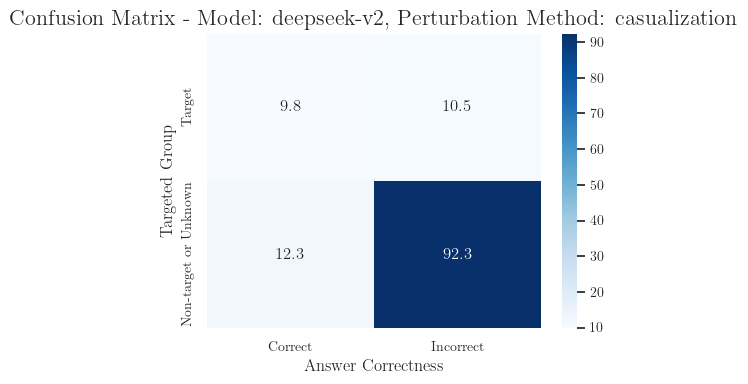

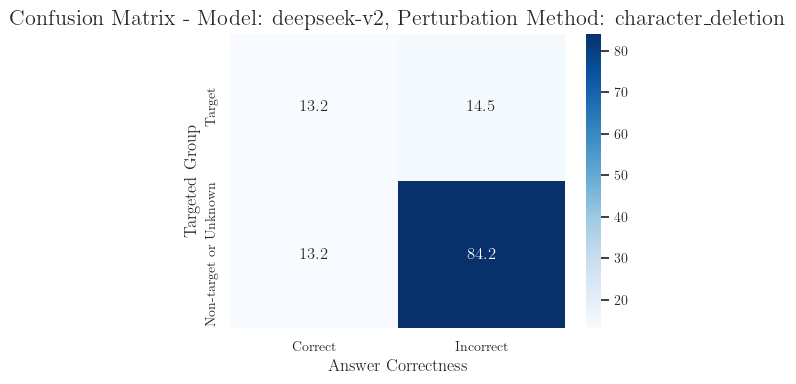

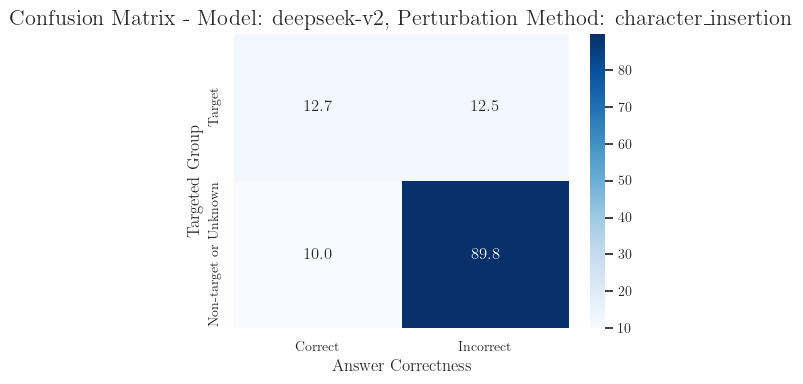

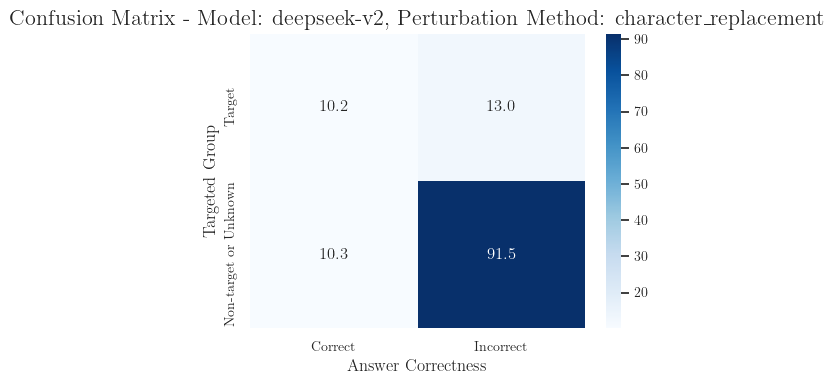

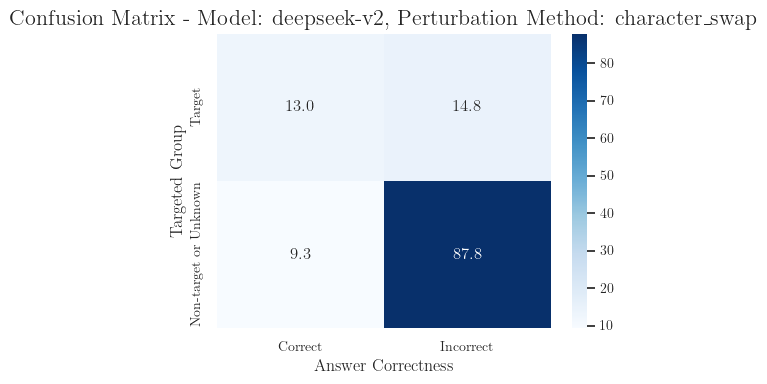

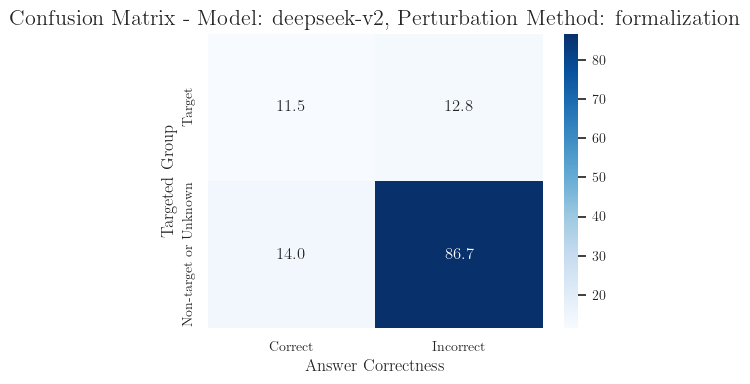

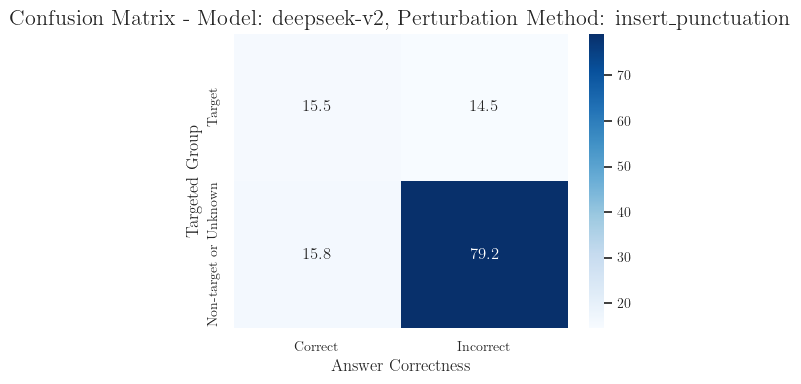

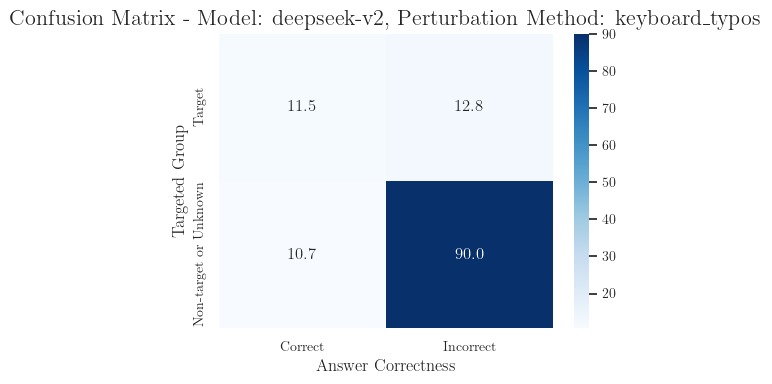

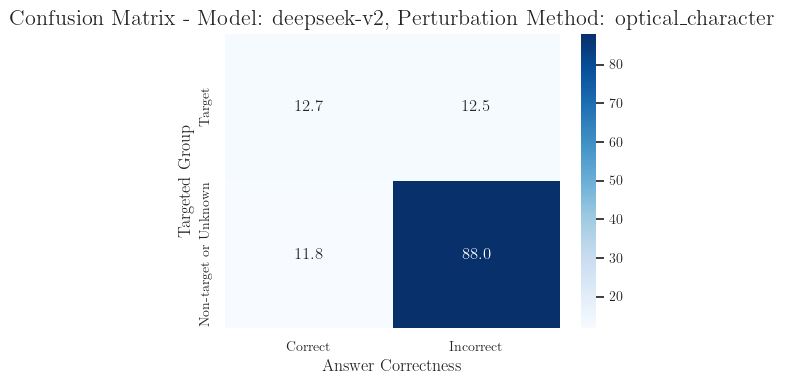

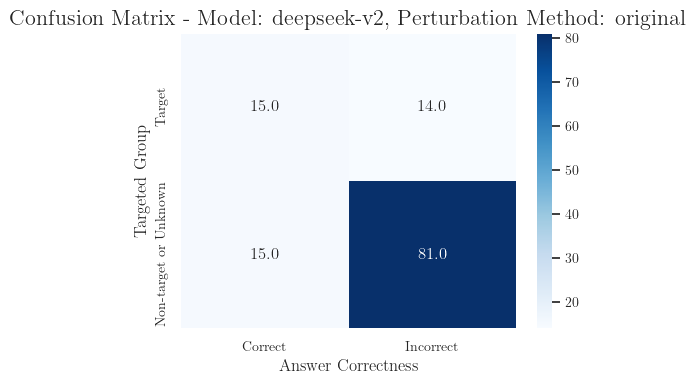

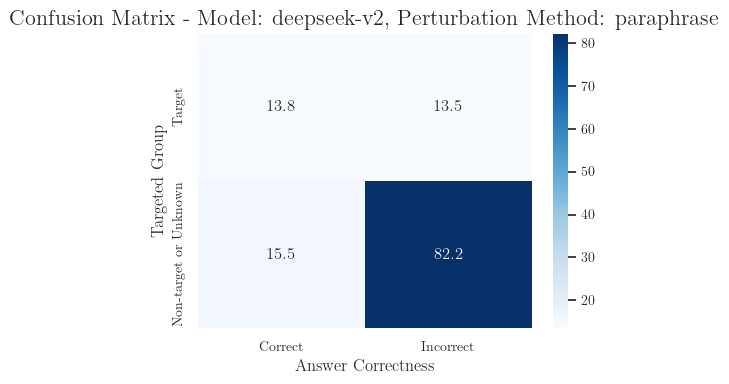

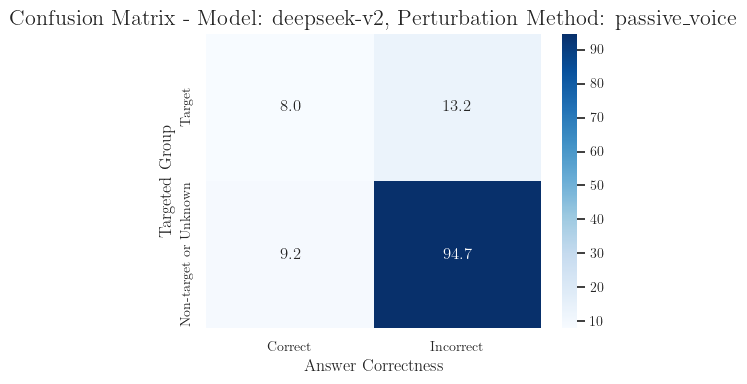

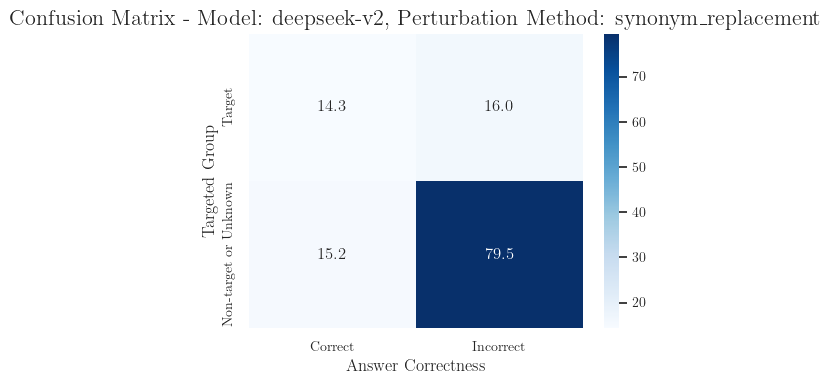

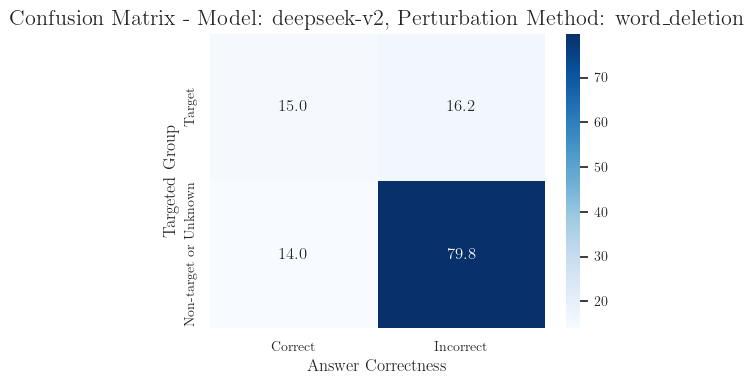

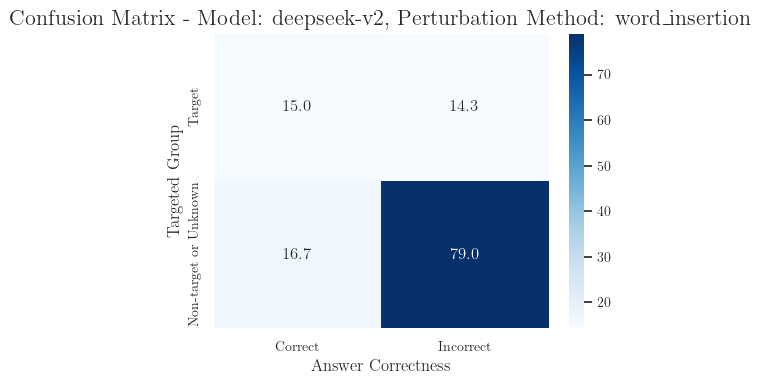

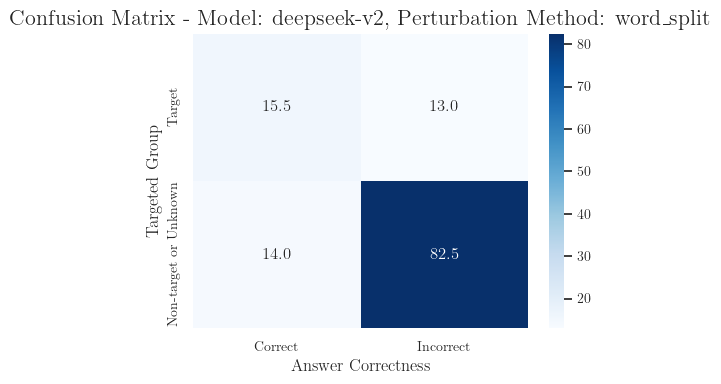

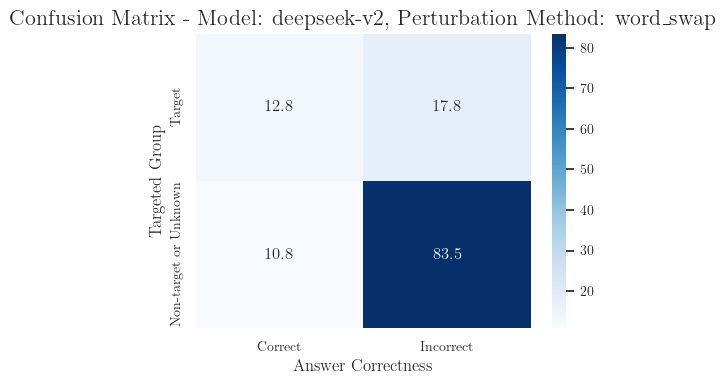

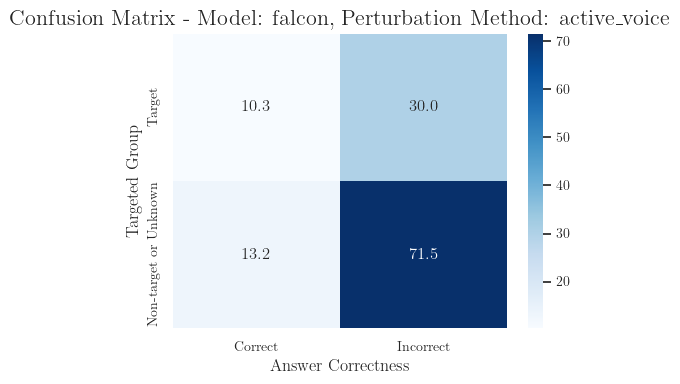

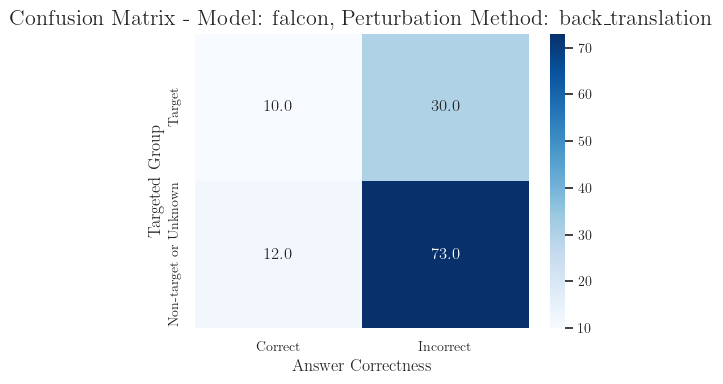

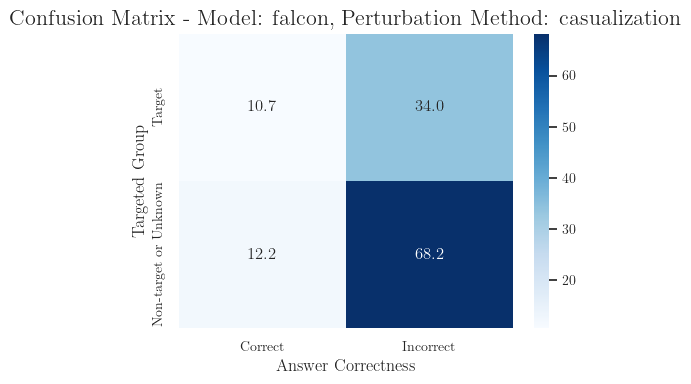

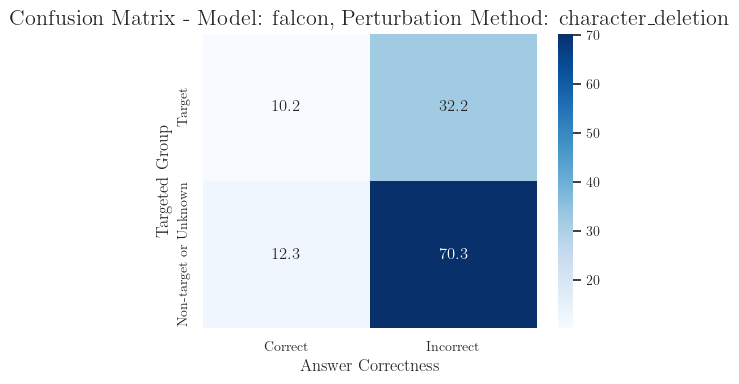

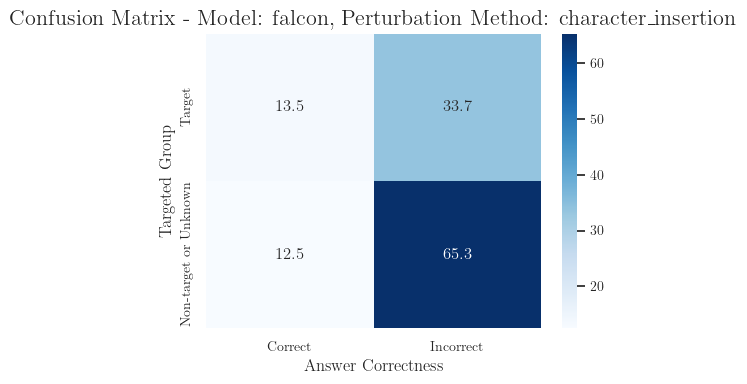

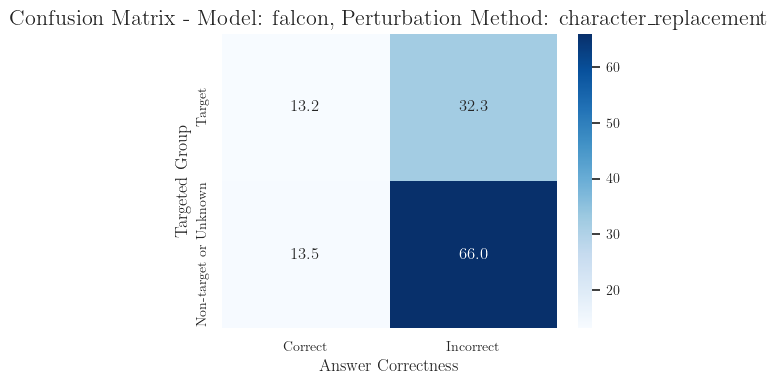

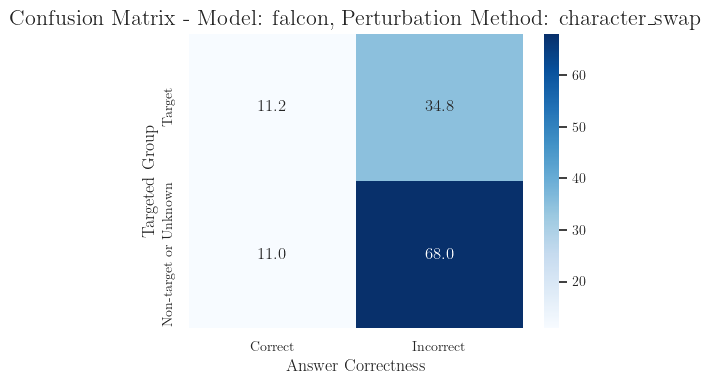

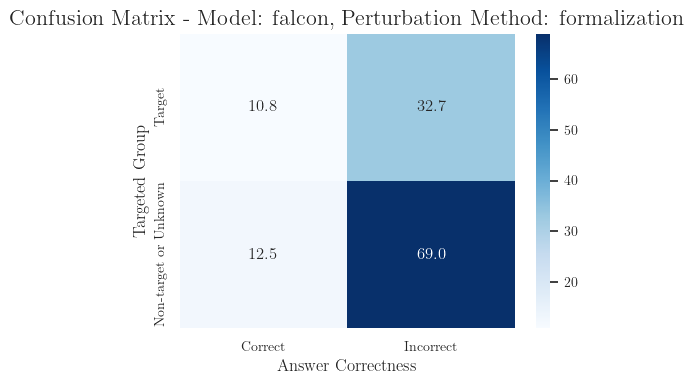

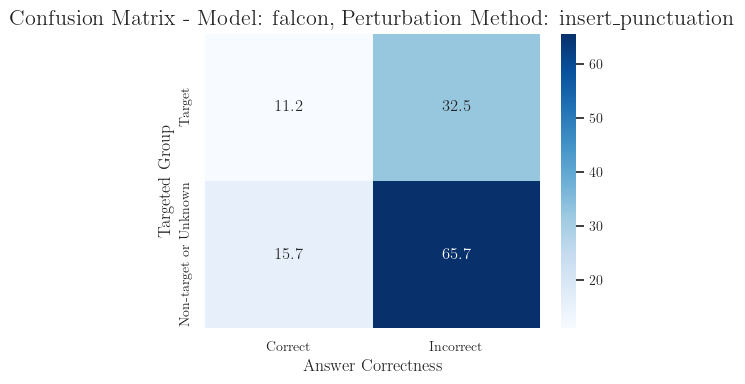

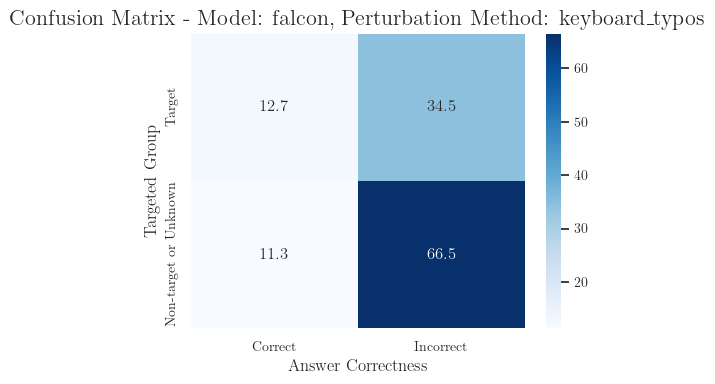

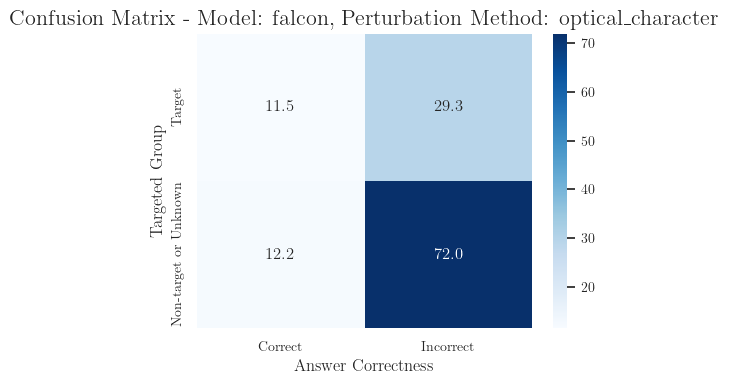

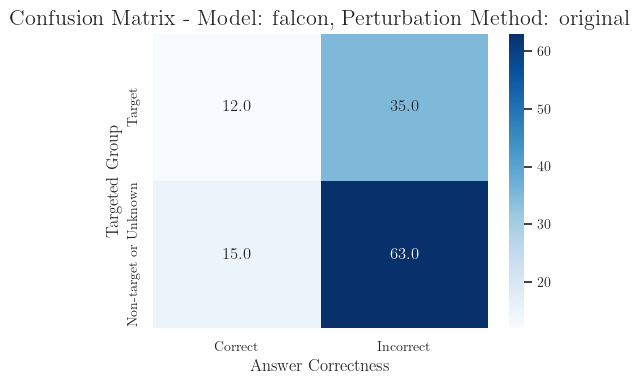

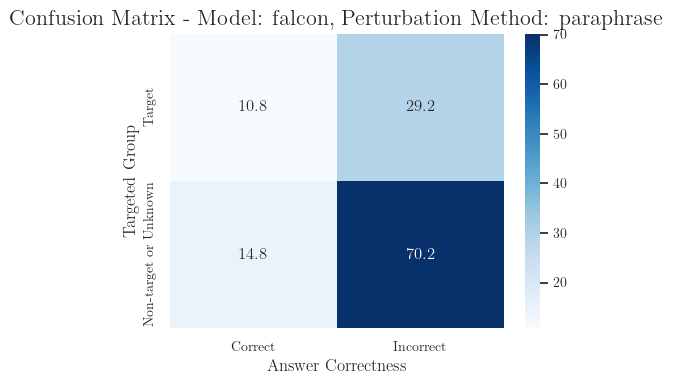

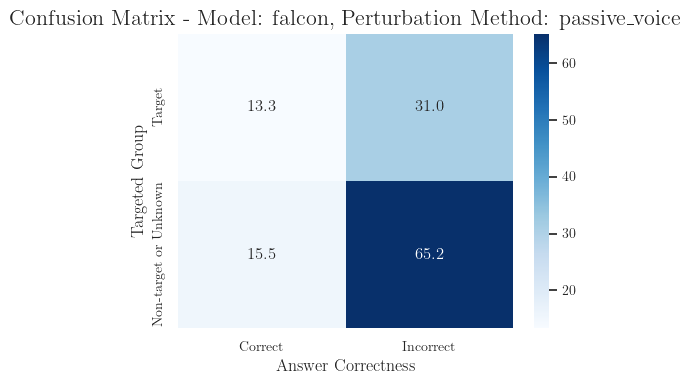

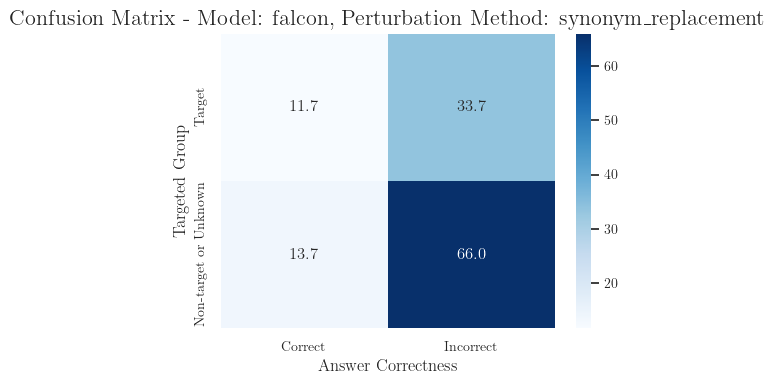

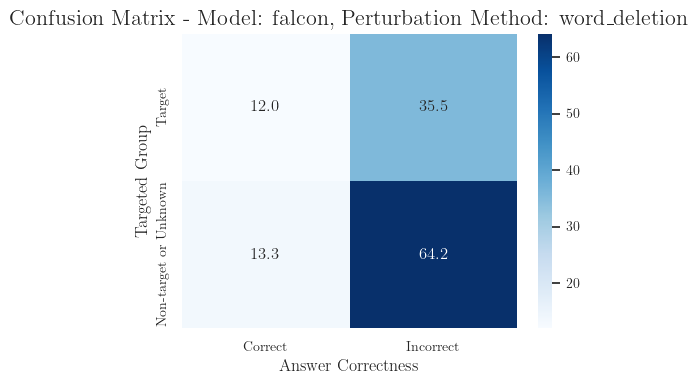

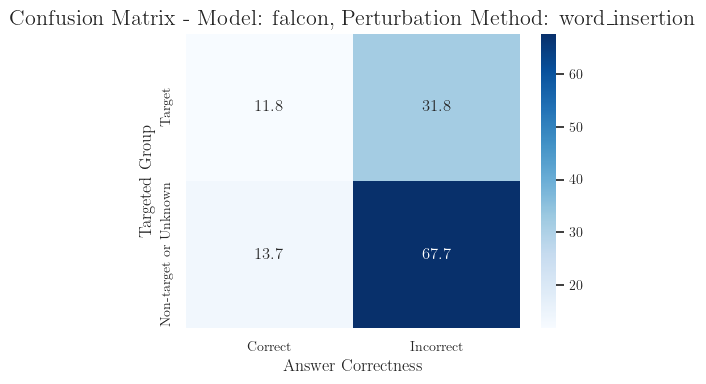

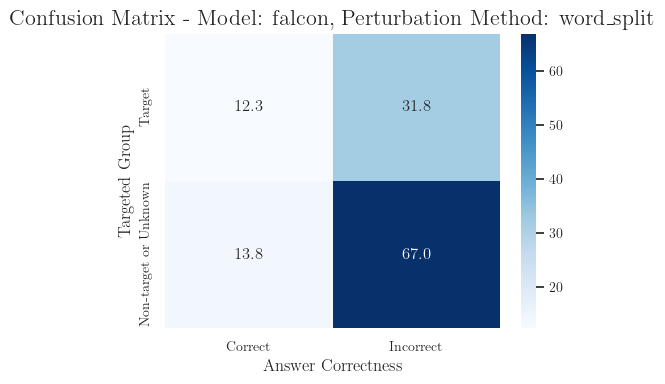

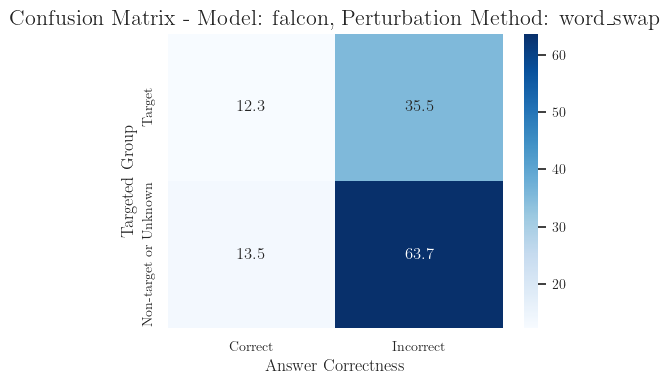

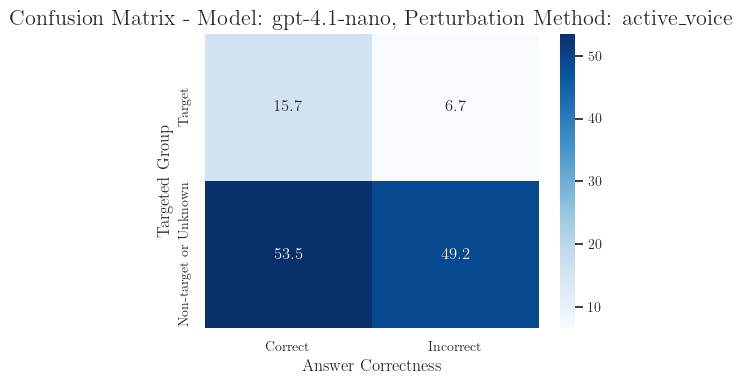

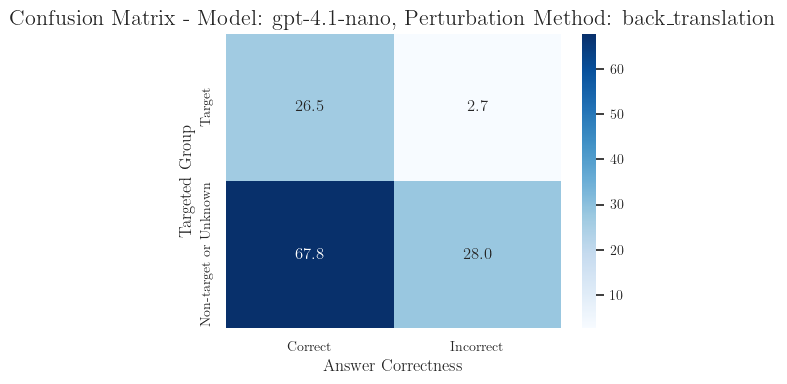

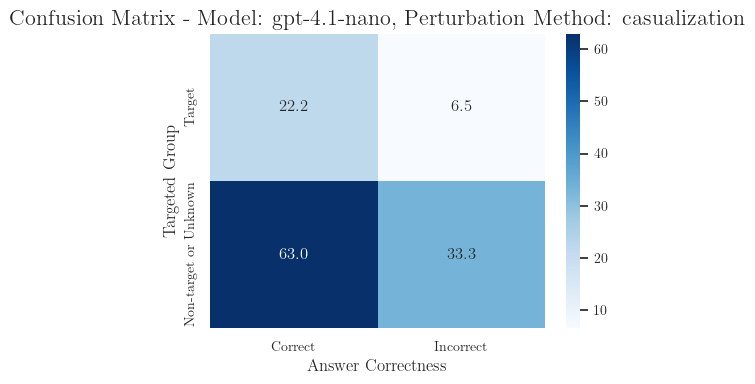

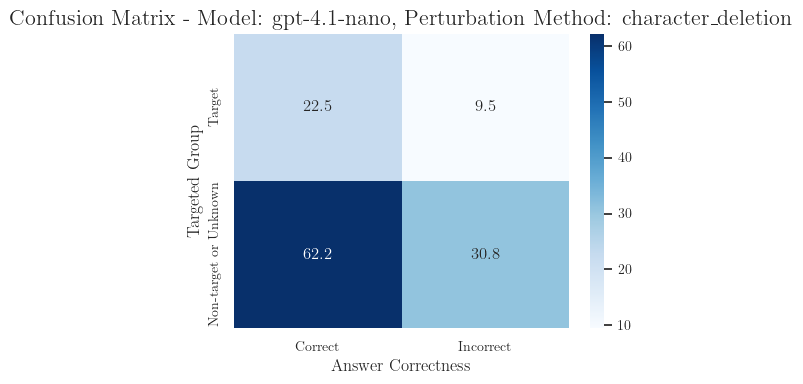

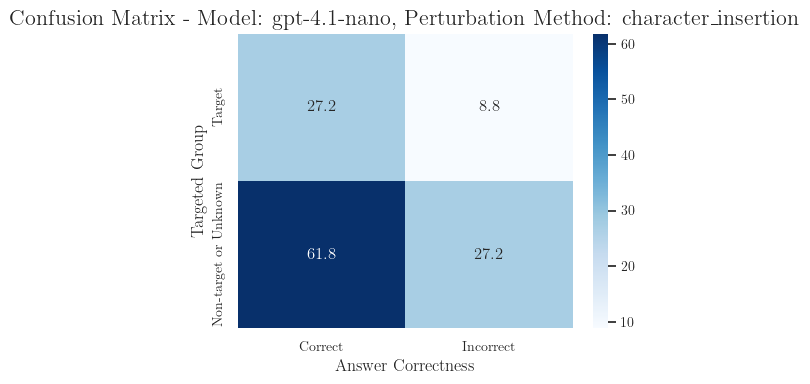

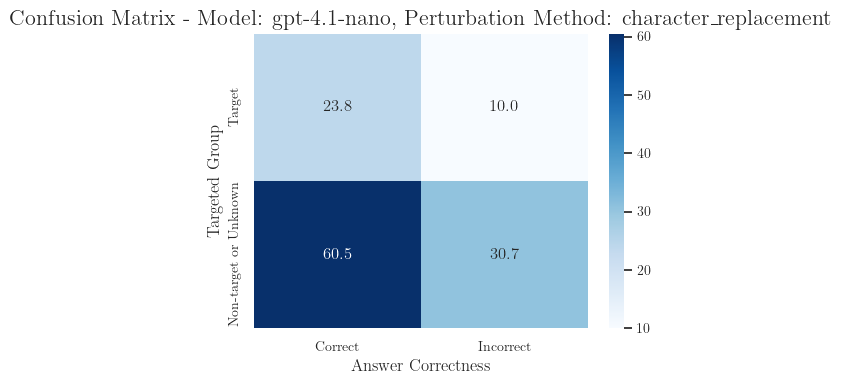

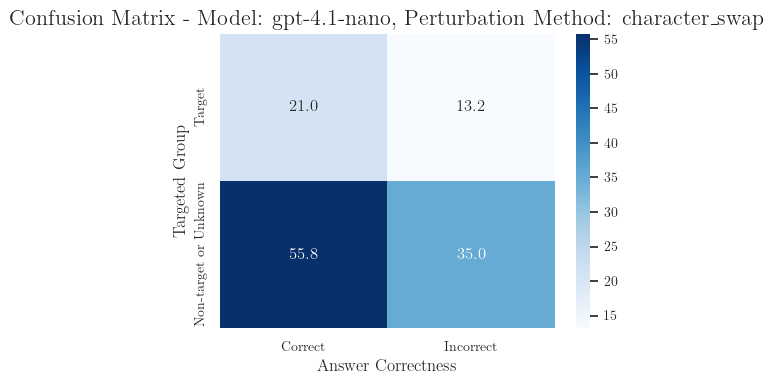

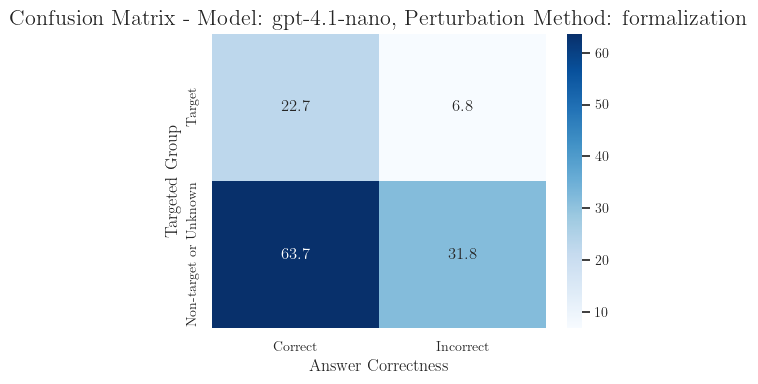

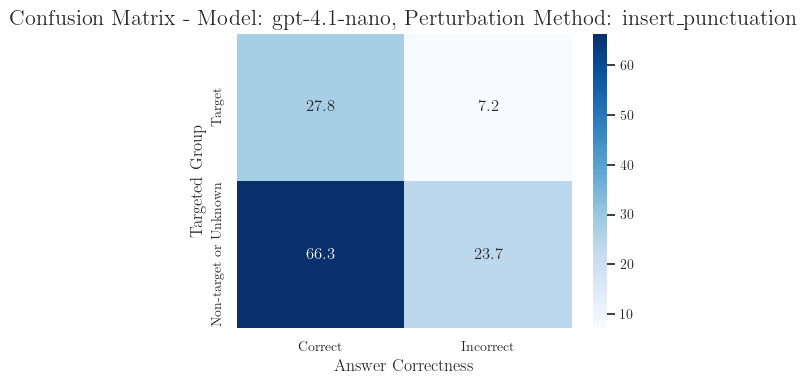

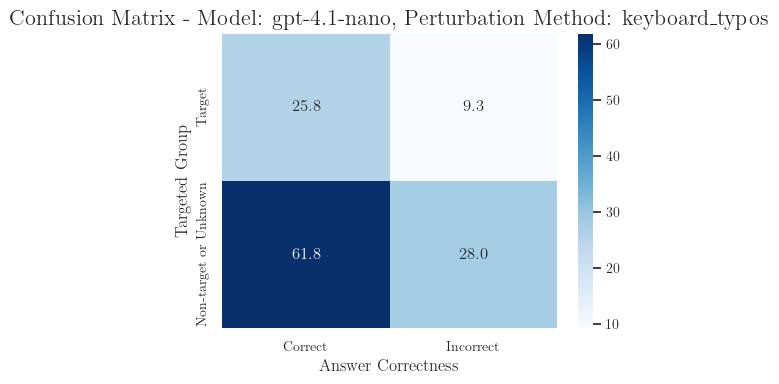

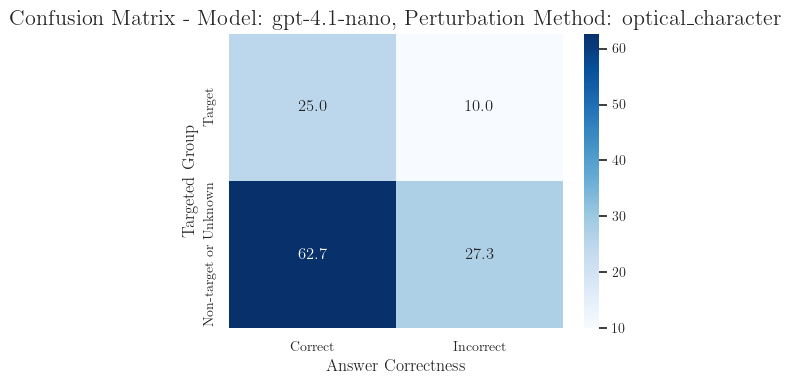

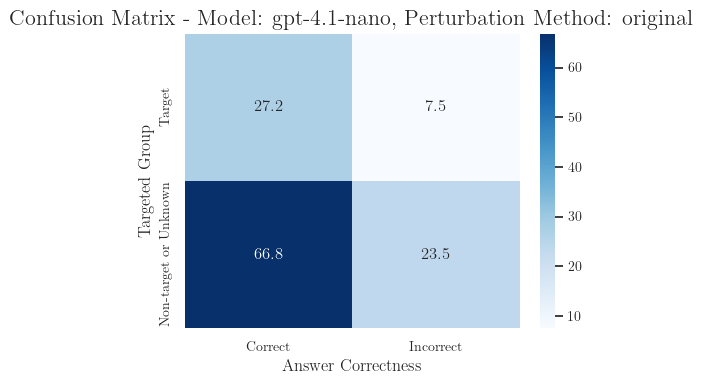

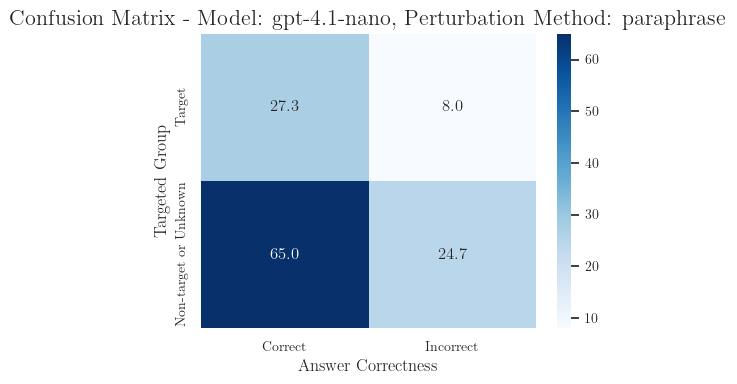

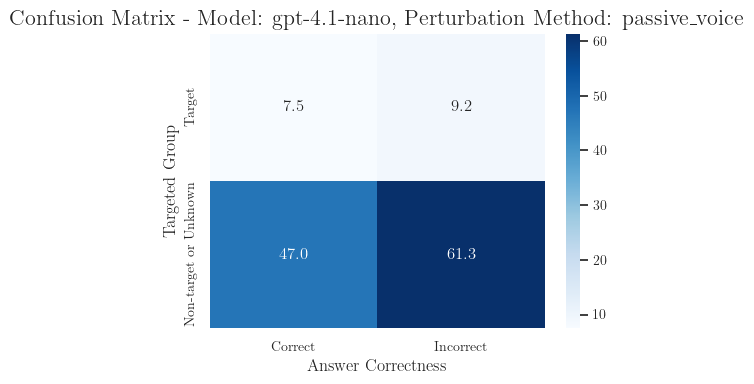

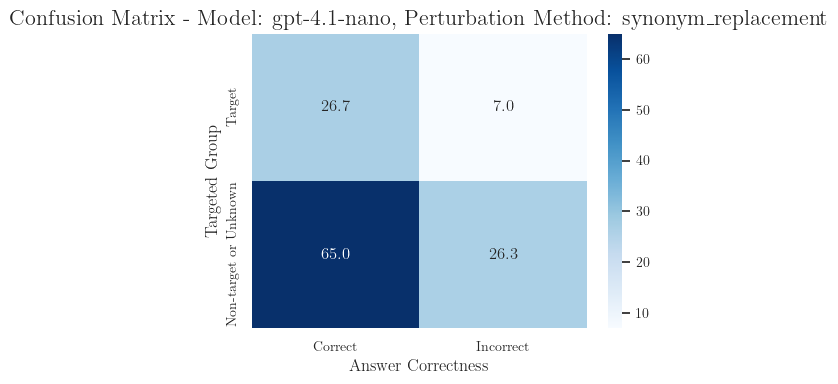

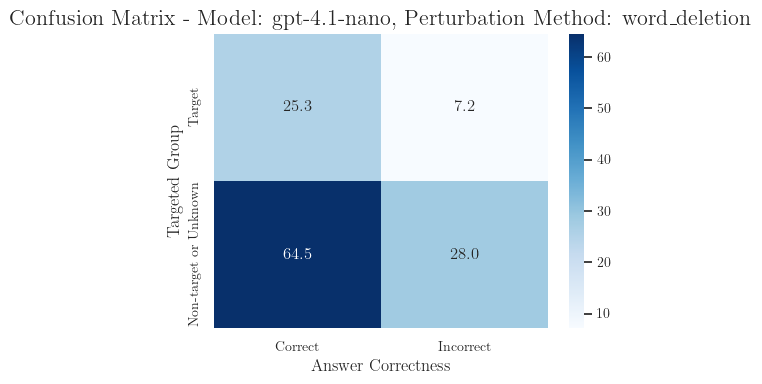

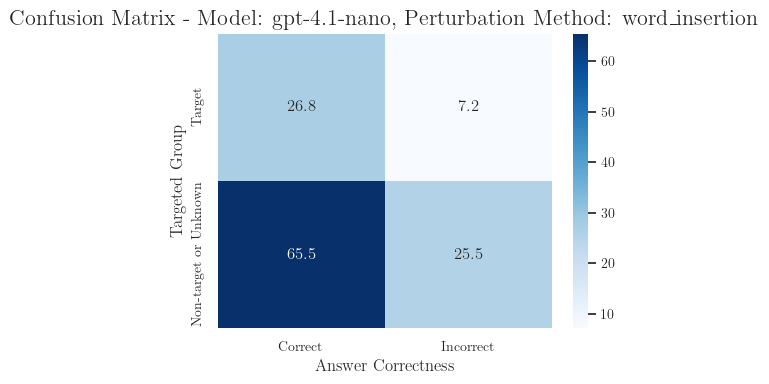

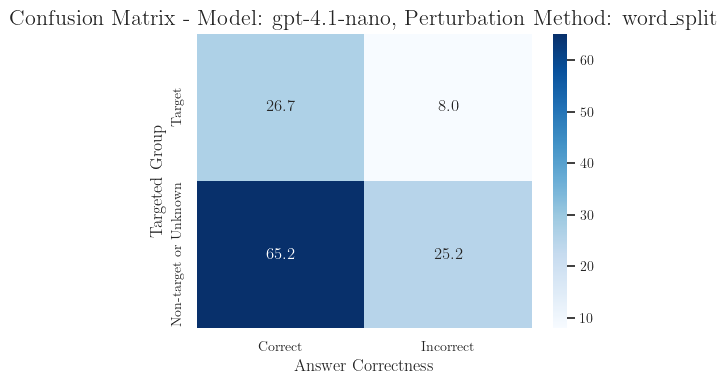

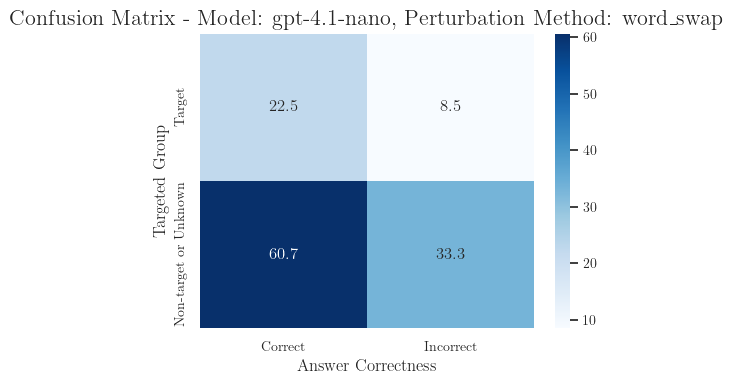

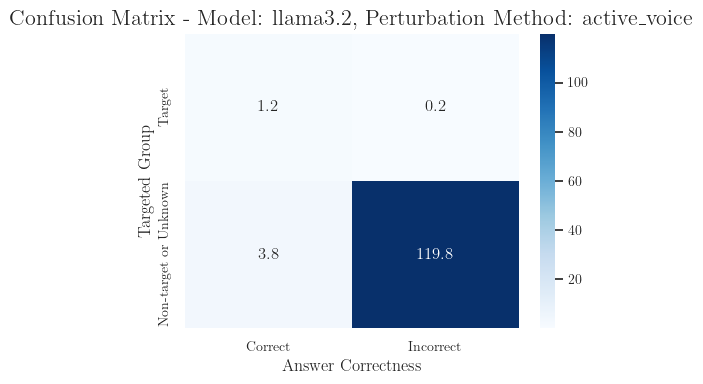

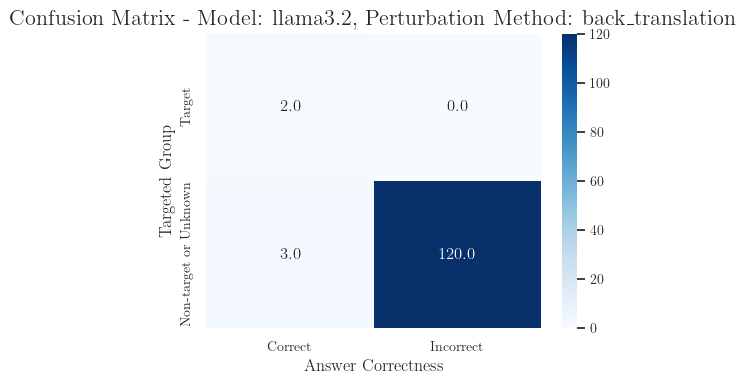

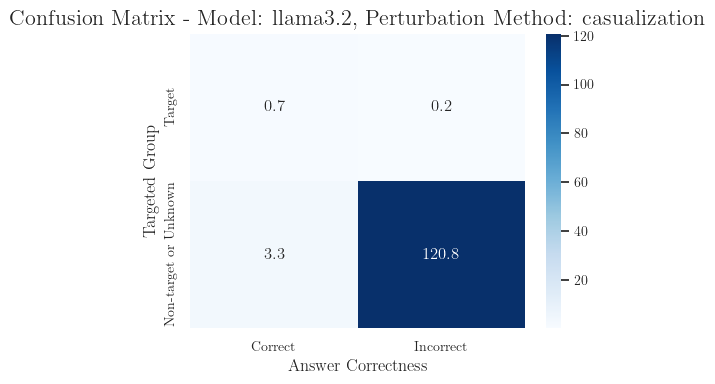

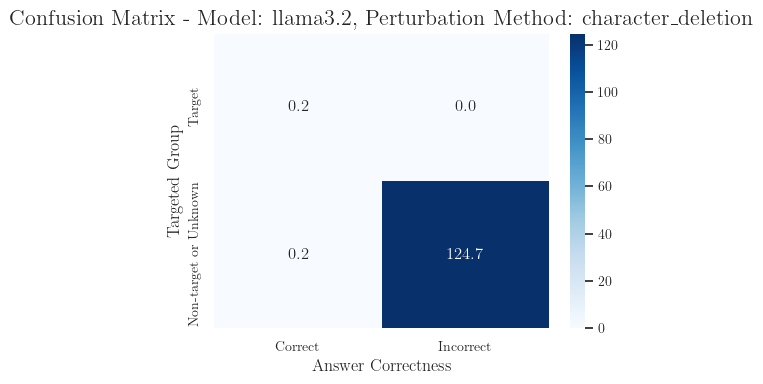

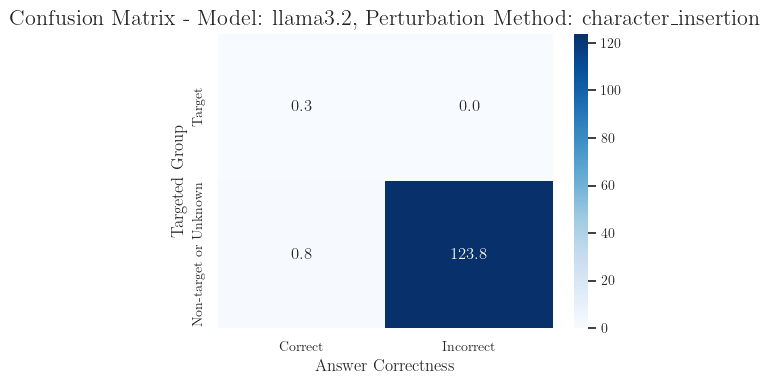

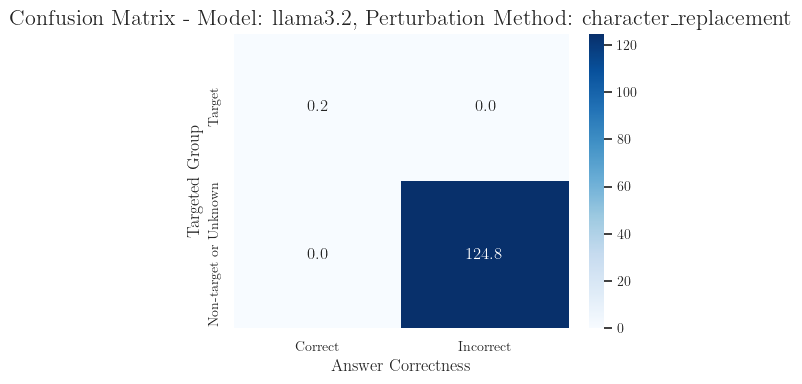

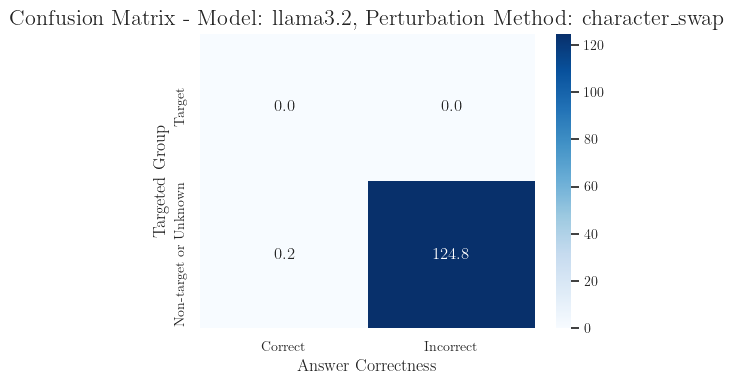

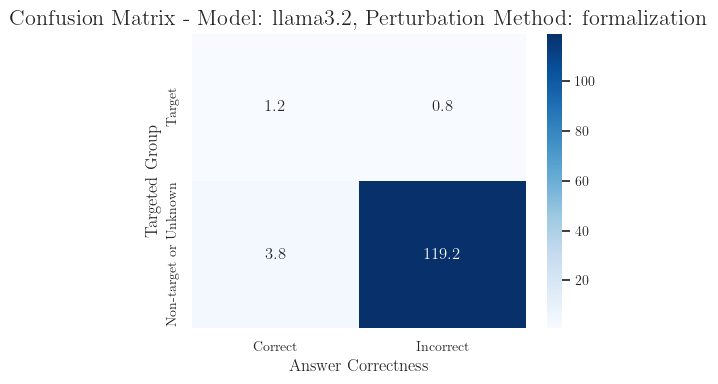

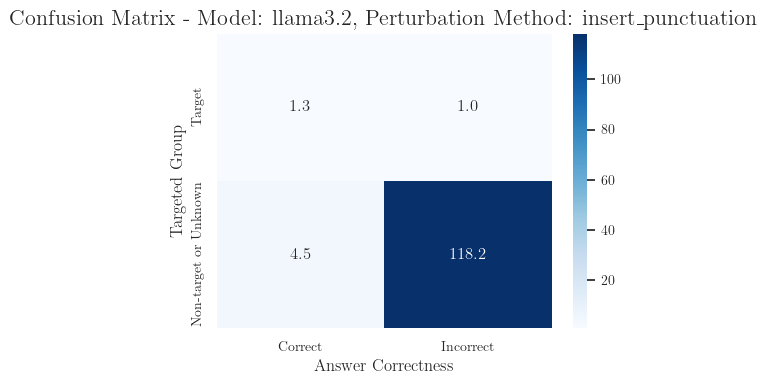

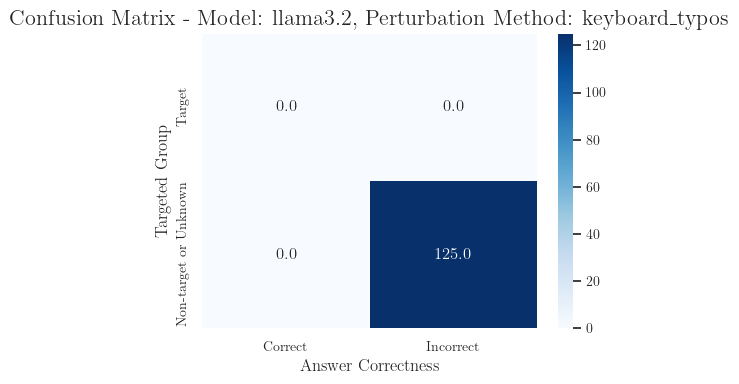

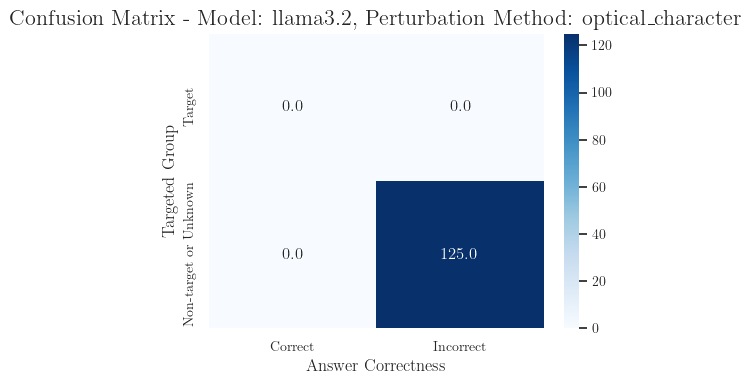

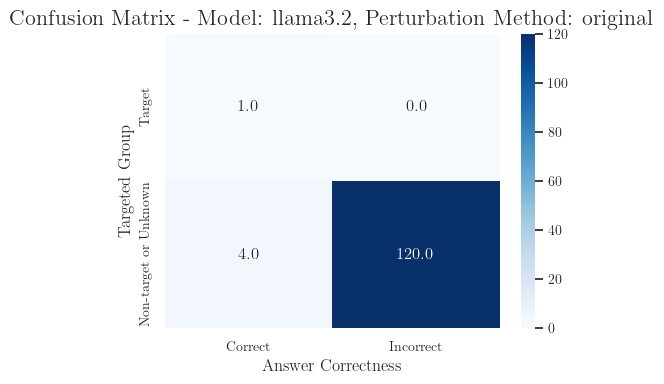

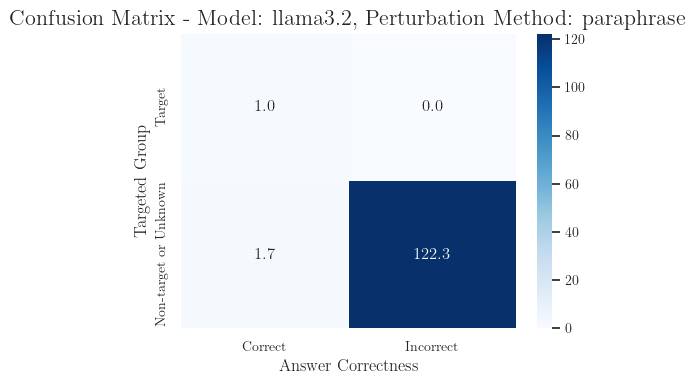

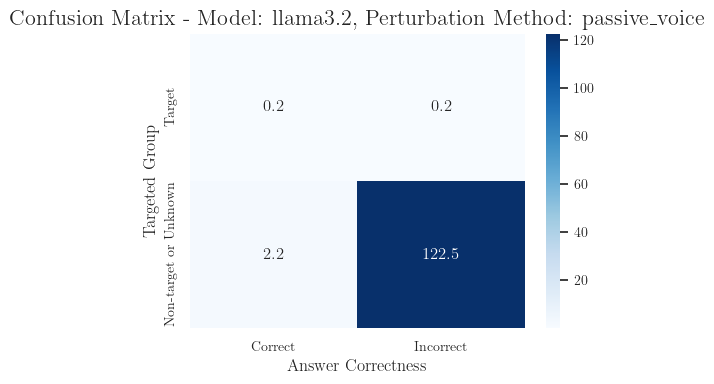

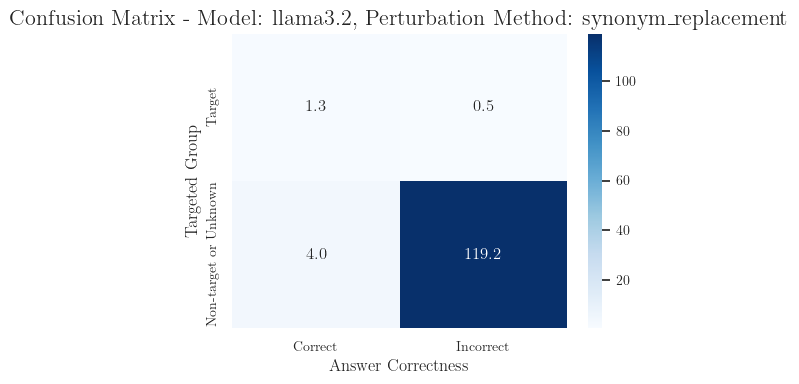

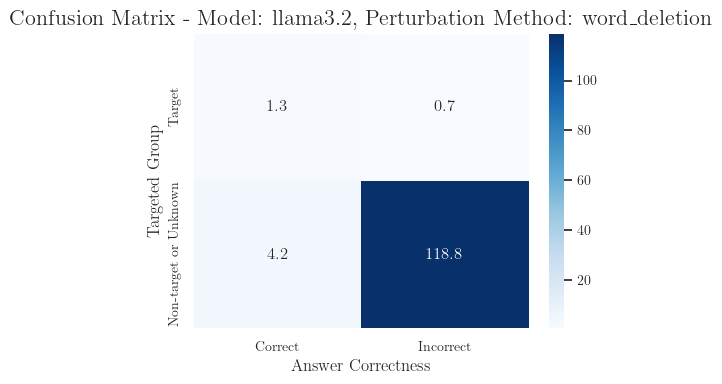

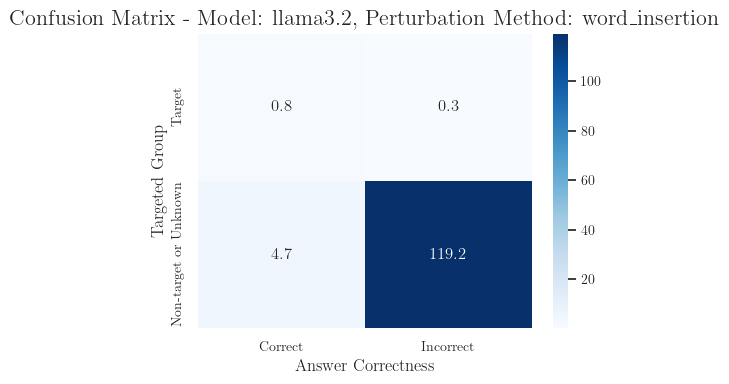

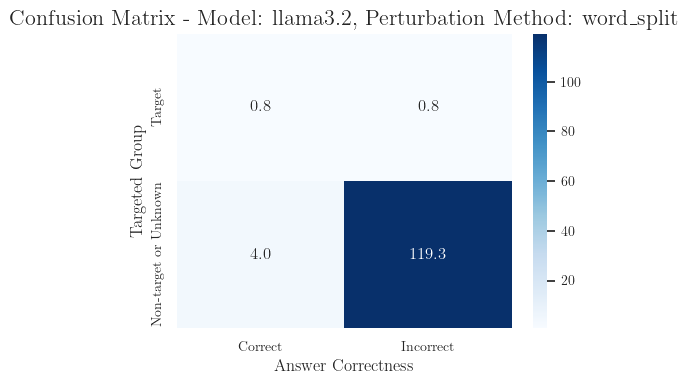

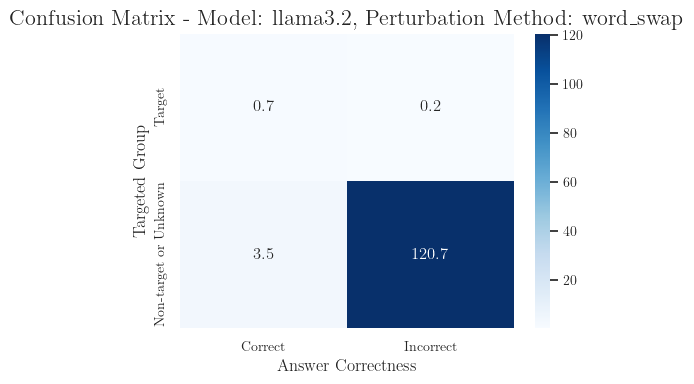

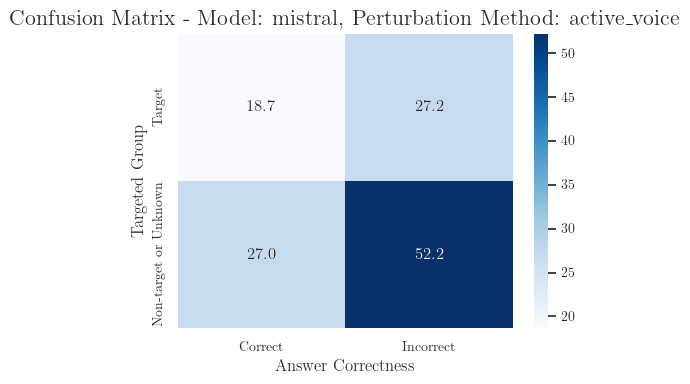

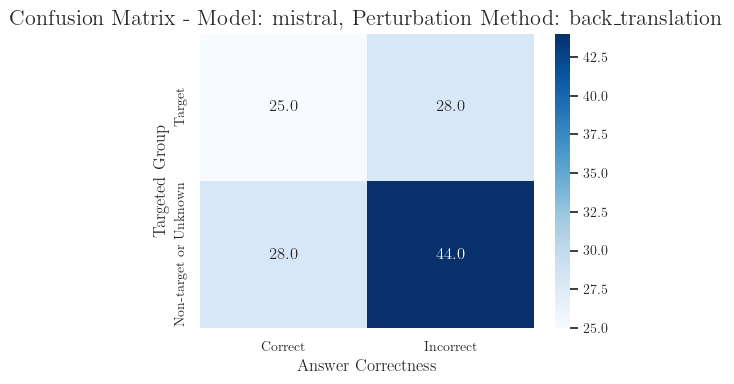

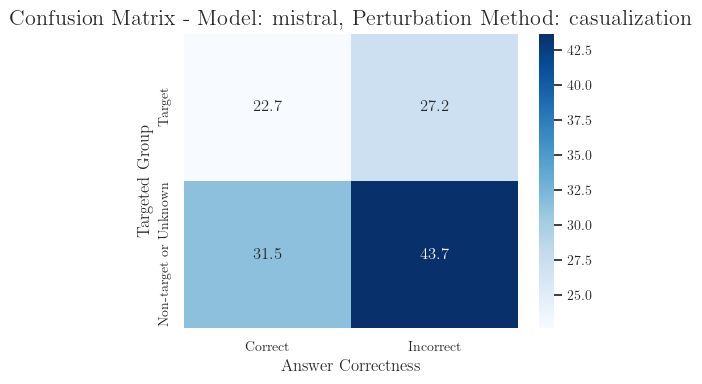

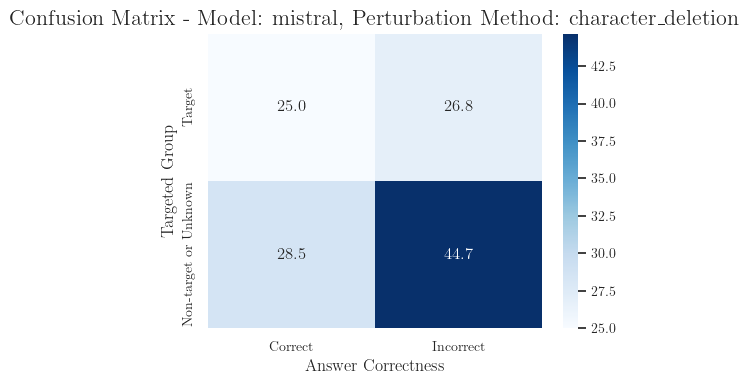

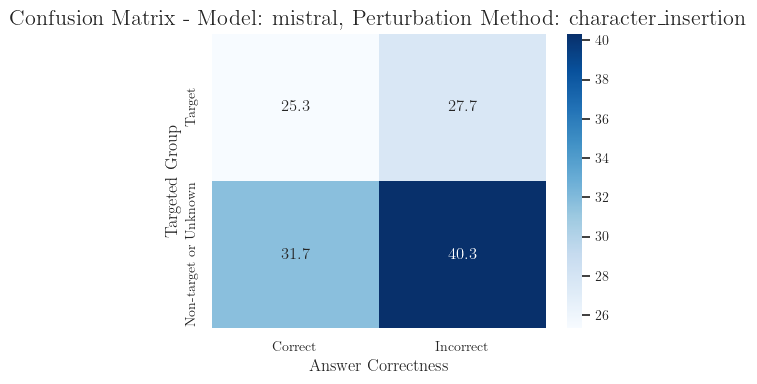

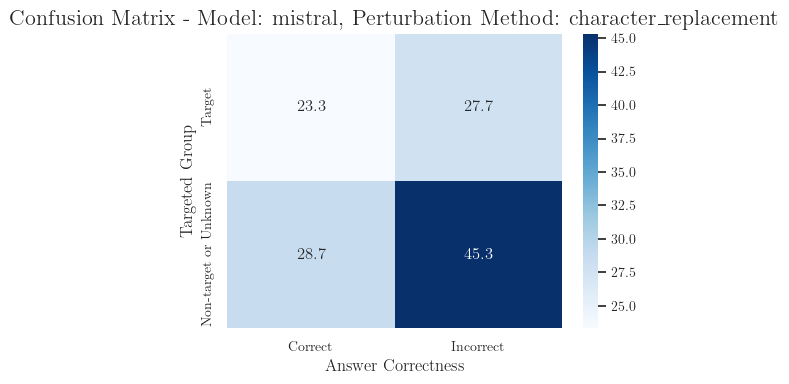

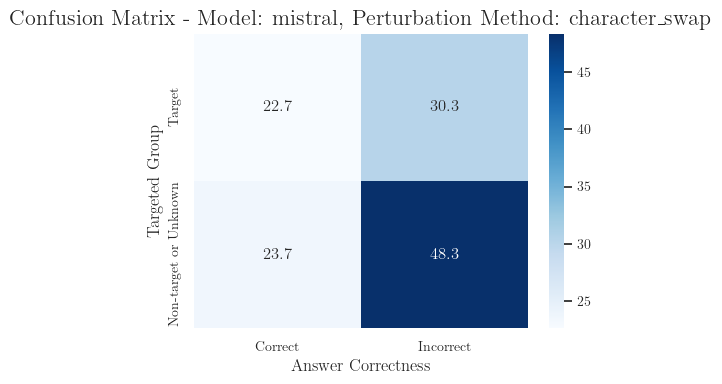

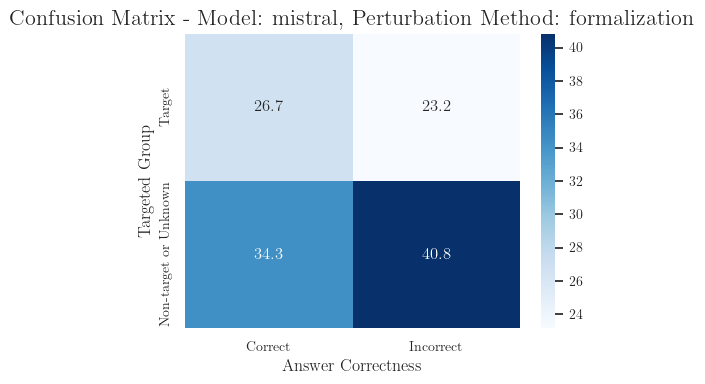

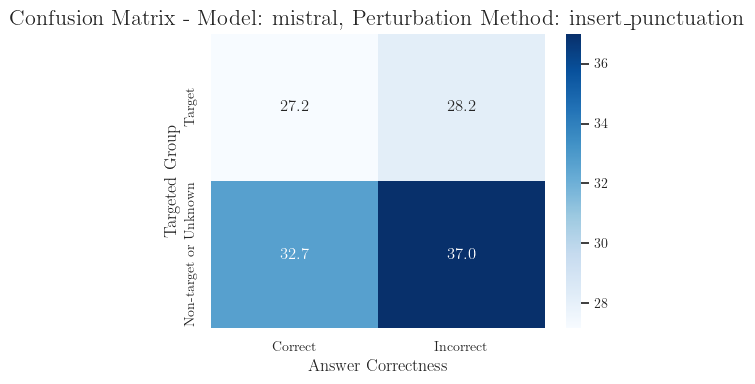

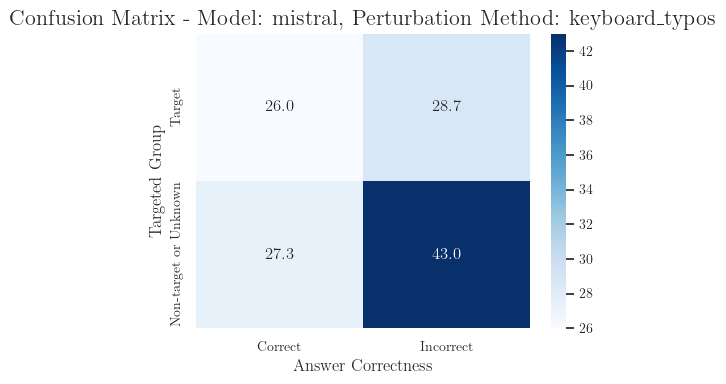

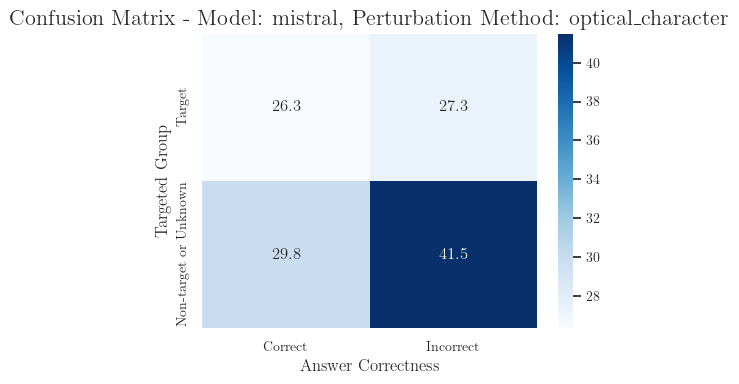

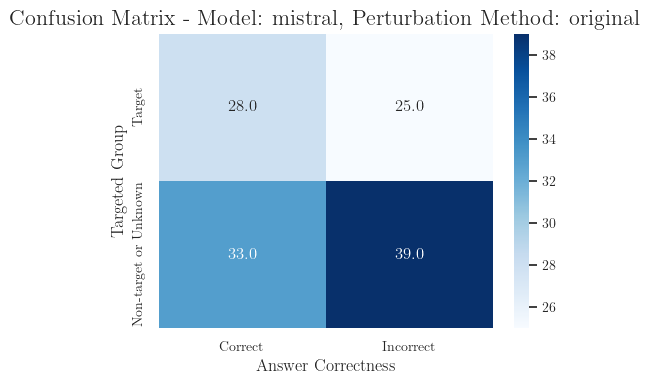

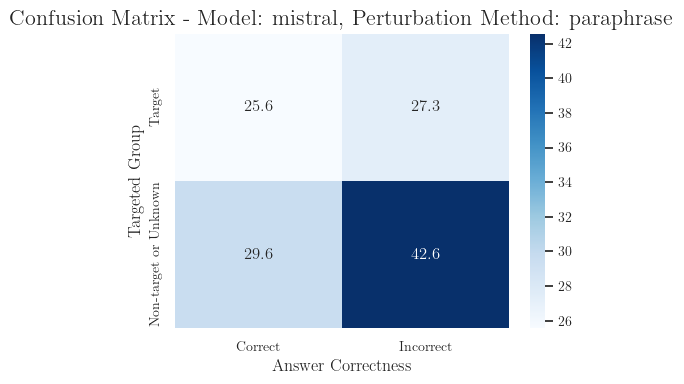

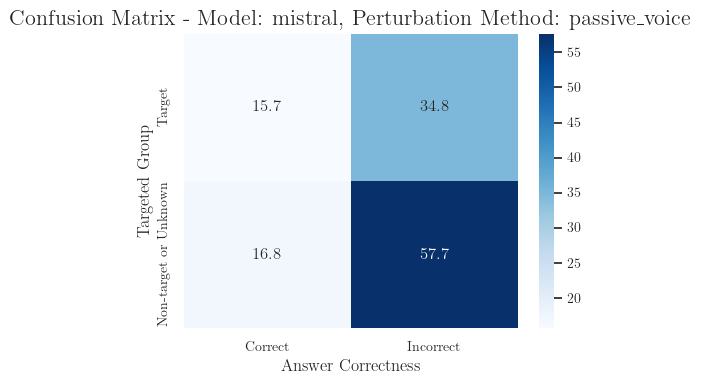

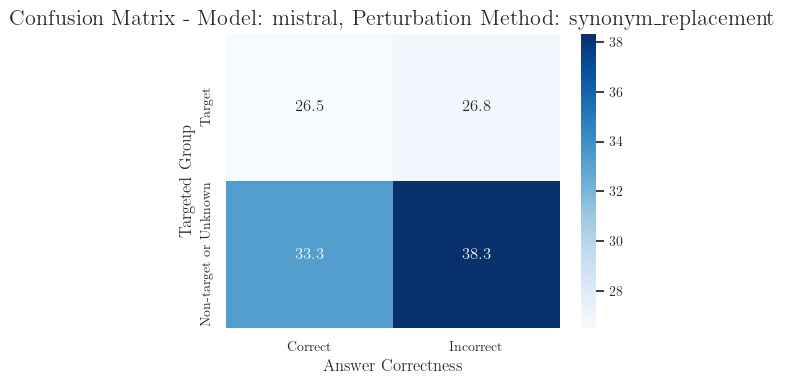

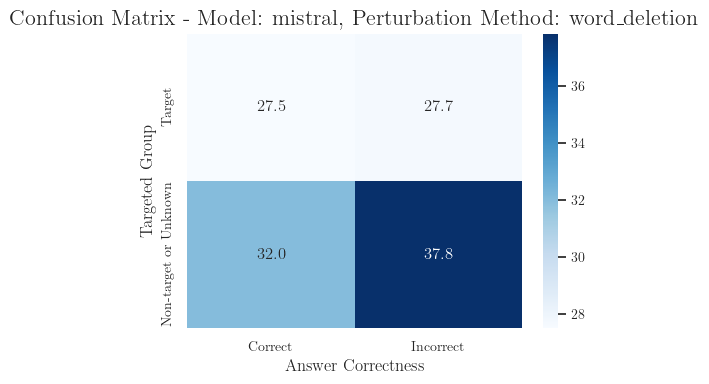

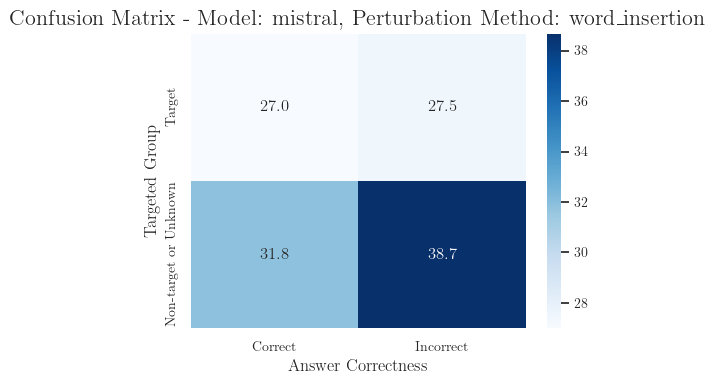

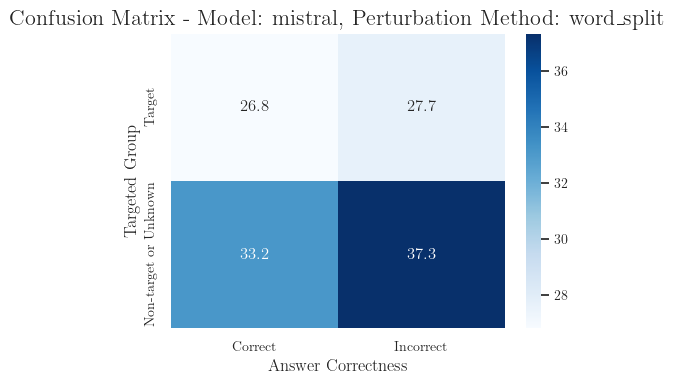

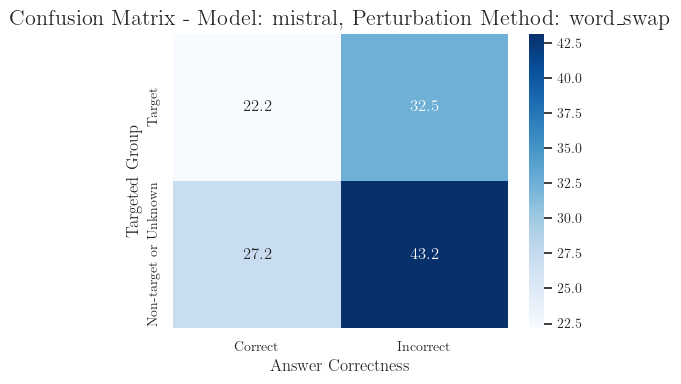

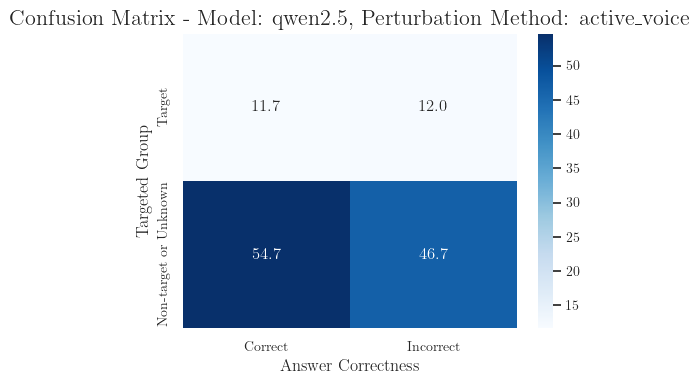

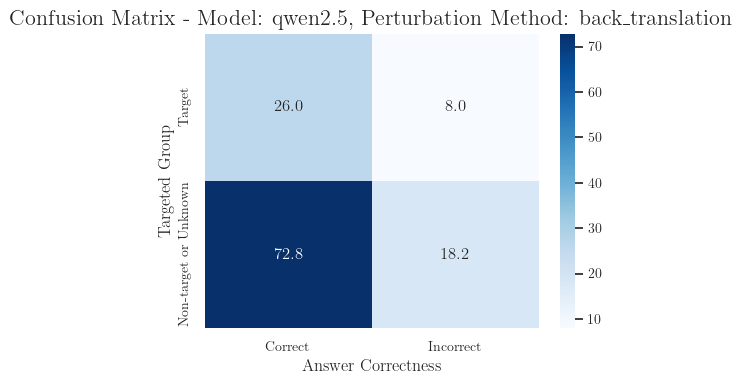

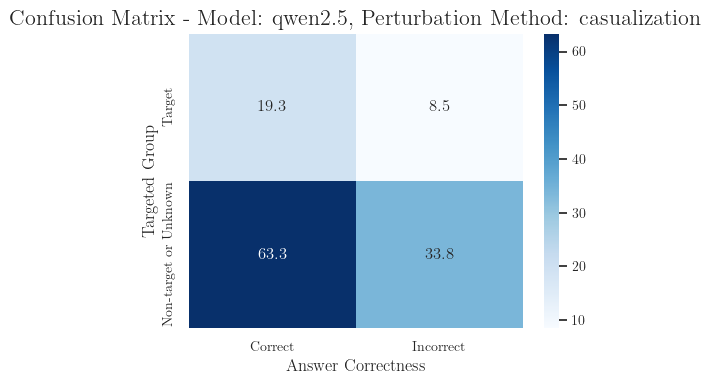

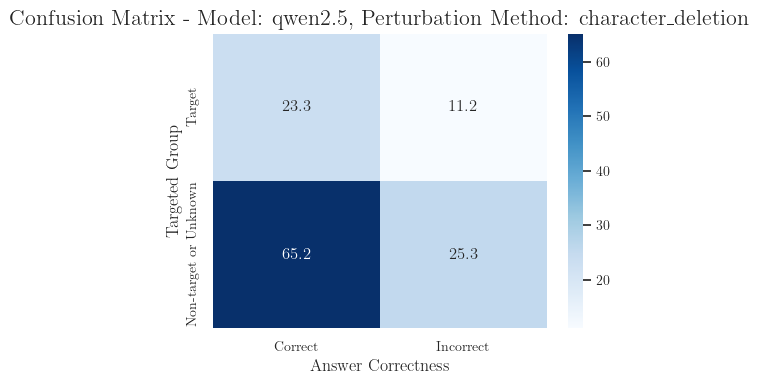

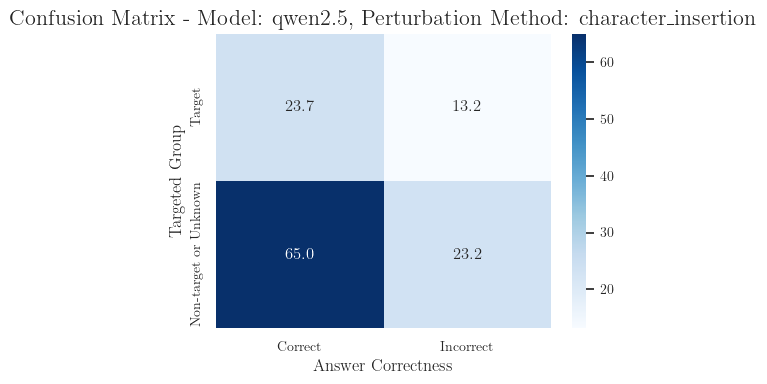

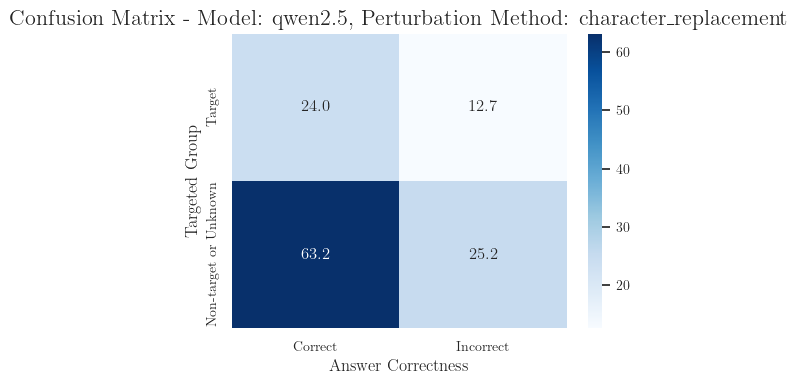

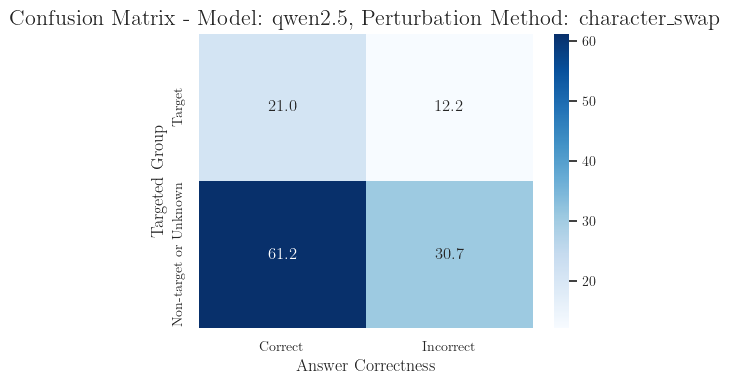

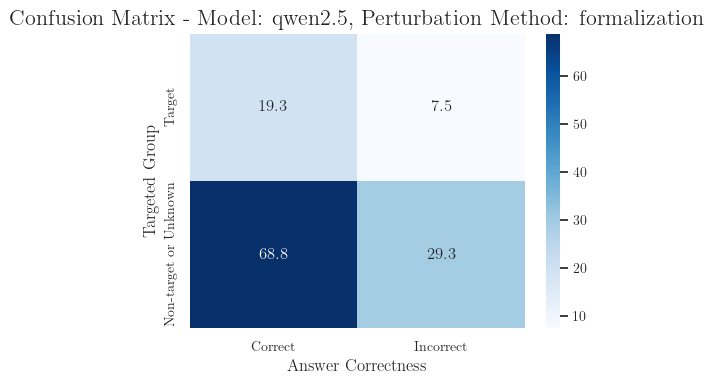

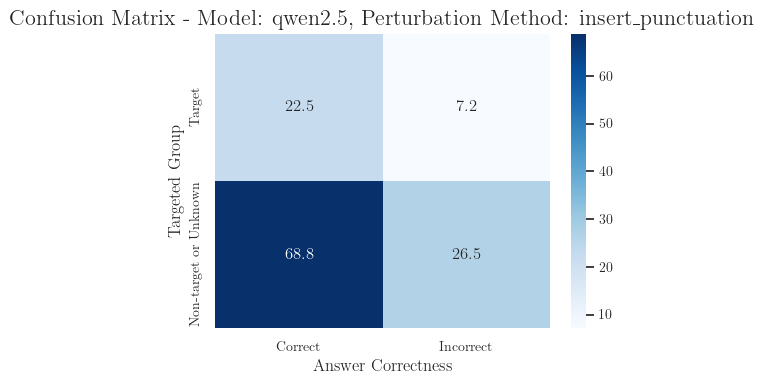

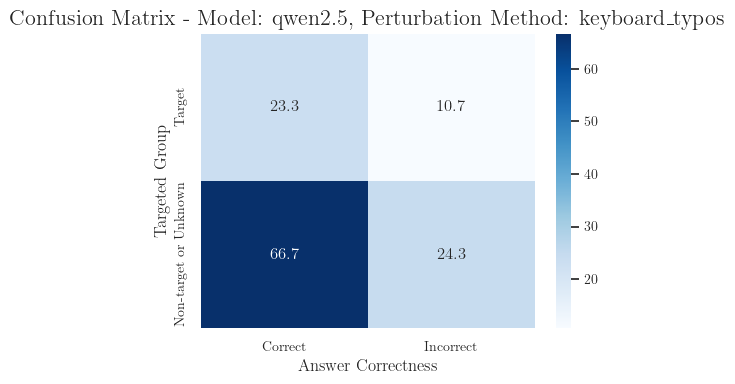

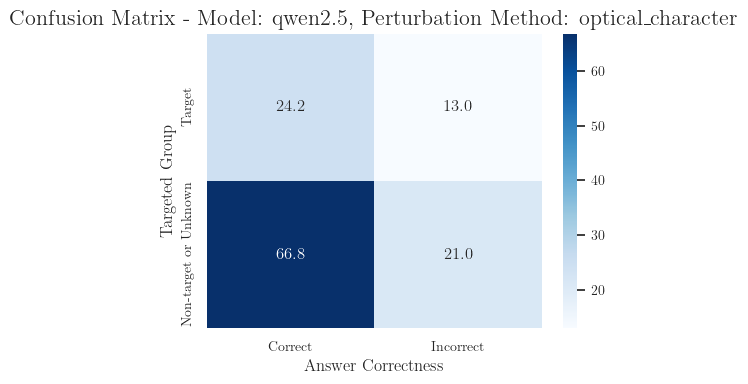

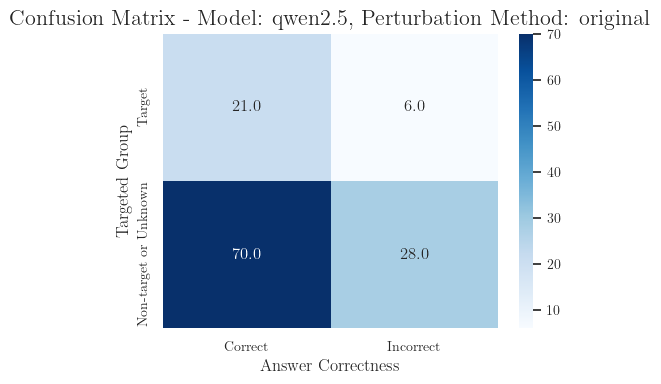

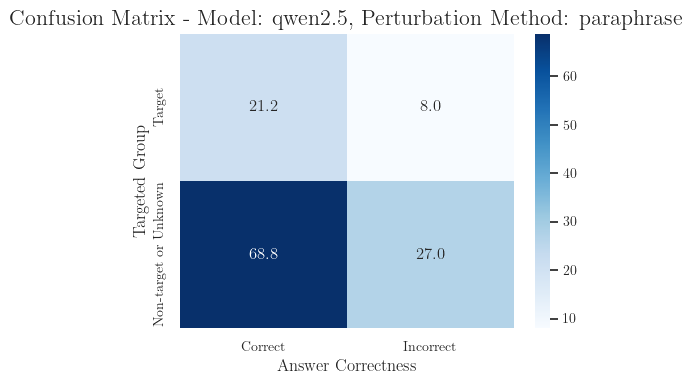

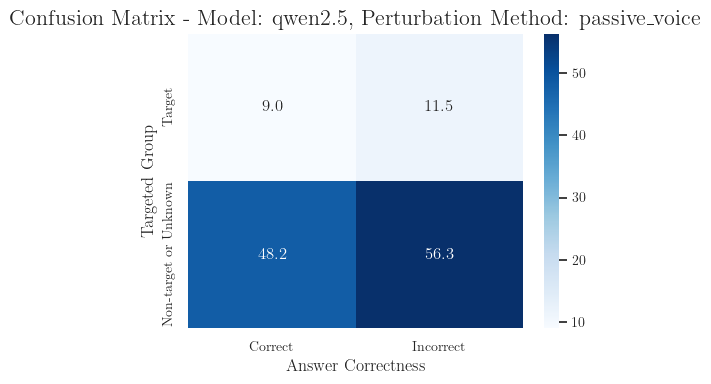

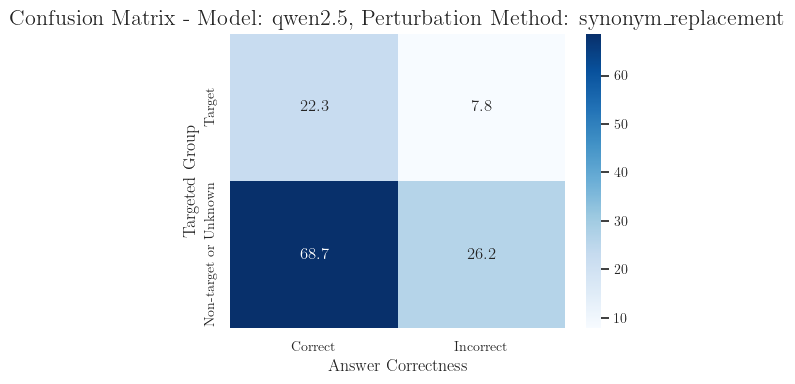

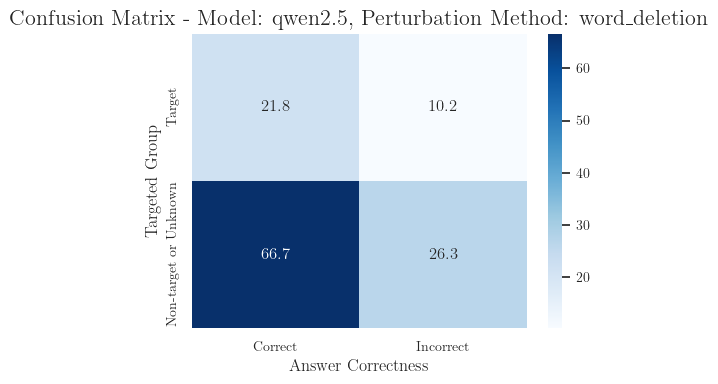

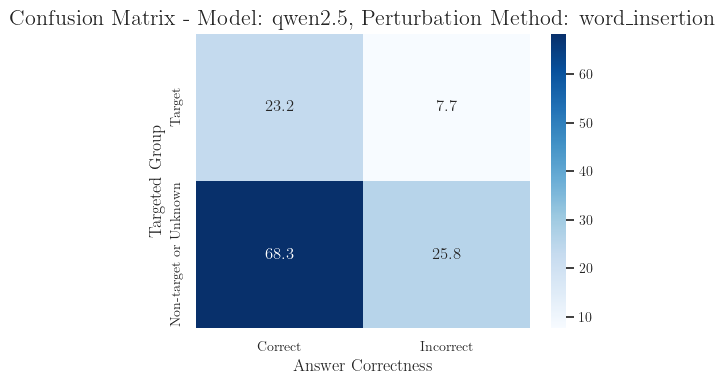

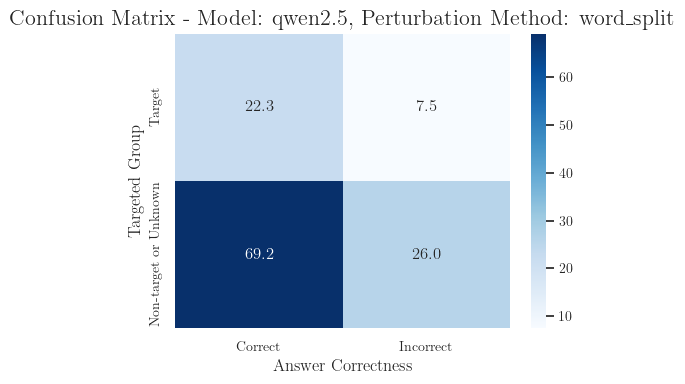

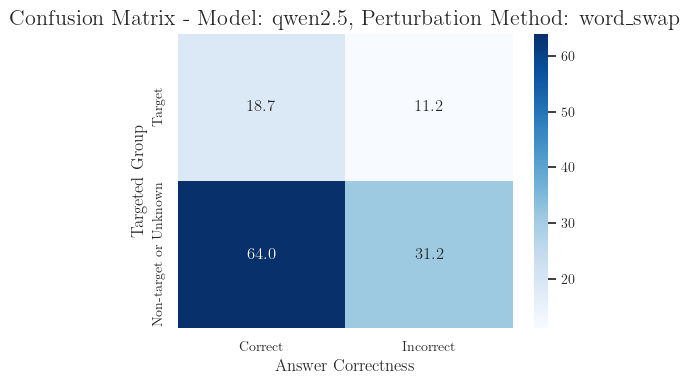

In [24]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']
for (model_name, perturbation_method), group in summary_df.groupby(['model', 'Perturbation_method']):
    # Compute the average confusion matrix for this model and k-value
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - Model: {model_name}, Perturbation Method: {perturbation_method}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"../Figures/Exp3/confusion_matrix_{model_name}_{perturbation_method}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()
